# Práctica APA

*   Pau Adell Raventos
*   Iván González Reguera

El conjunto de datos que hemos elegido se denomina Bilbao Real Estate, este consiste en más de 3000 datos sobre la mediana ciudad Bilbao situada en el norte de España. Hemos encontrado este dataset en [Kaggle](https://www.kaggle.com/datasets/mexwell/bilbao-real-estate/) aunque su fuente original es [Zenrows](https://www.zenrows.com/datasets/bilbao-real-estate). El objetivo seria predecir los precios de las viviendas con los datos proporcionados. Es decir esto es un problema de regresión, ya que no tenemos que clasificar nada sino hacer una aproximación de un valor (el precio).
Vamos a cargar los datos y ver las condiciones en las que están.

In [ ]:
!pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 2.6 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
from pandas.plotting import scatter_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import plotly.express as px
from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

# Lo siguiente es para el resaltado de líneas y errores mediante colores, una sintaxis adicional para el control de la shell, y más. Se utiliza ampliamente con Jupyter Notebook y otros entornos interactivos de Python
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
def find_folder(folder_name, start_path='/content/drive/My Drive'):
    for root, dirs, files in os.walk(start_path):
        if folder_name in dirs:
            return os.path.join(root, folder_name)
    return None

shared_folder_path = find_folder("APA")

bilbaorealstate =  pd.read_csv(shared_folder_path + "/bilbao-real-estate.csv", header=0, delimiter=',')
bilbaorealstate.head()

,price,formattedPrice,dateTimestamp,coordinatesAcc,latitude,longitude,accuracy,country,customZone,district,...,bathrooms,floor,heating,elevator,balcony,rooms,surface,terrace,heater,conservationState
0,475000.0,475.000 €,1622565227557,0,43.25794,-2.925409,False,España,NaN,Ibaiondo,...,2.0,8.0,1.0,1.0,1.0,5.0,189.0,NaN,NaN,NaN
1,NaN,NaN,1622565227473,0,43.26497,-2.936796,False,España,NaN,Indautxu,...,3.0,9.0,1.0,1.0,NaN,4.0,250.0,1.0,NaN,NaN
2,895000.0,895.000 €,1622565227377,0,43.26373,-2.936043,False,España,NaN,Abando - Albia,...,3.0,9.0,1.0,1.0,1.0,5.0,200.0,1.0,NaN,NaN
3,259000.0,259.000 €,1622565227373,0,43.25930,-2.911708,False,España,NaN,Uribarri,...,2.0,9.0,NaN,1.0,NaN,2.0,90.0,NaN,1.0,NaN
4,490000.0,490.000 €,1622565227353,0,43.25975,-2.923125,False,España,NaN,Ibaiondo,...,2.0,10.0,NaN,1.0,NaN,3.0,150.0,NaN,1.0,NaN


Como podemos ver con la función de head tenemos 63 variables de las cuales hay tanto numéricas como categóricas e incluso alguna categórica ya se indica numéricamente con valores de ceros y unos (haciendo referencia a cierto o falso). También podemos ver variables que les falta información (con NaN).
Veamos de forma más detallada cuáles son todas nuestras variables para ver si requieren algún trabajo de procesamiento y sus valores:

In [ ]:
# Iterating through each column
for column_name, column_data in bilbaorealstate.iteritems():
    # Check if the column is numerical
    if pd.api.types.is_numeric_dtype(column_data):
        # Get descriptive statistics for numerical columns
        print(f"Statistics for {column_name} (Numerical):")
        print(column_data.describe())
    else:
        # Assuming non-numerical data is categorical
        # If you specifically want to handle string/object types only, you can add that condition here.
        print(f"Value counts for {column_name} (Categorical):")
        print(column_data.value_counts())

    # Adding a separator for readability
    print("-" * 40)

<ipython-input-4-153a700e5d5f>:2: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column_name, column_data in bilbaorealstate.iteritems():


Statistics for price (Numerical):
count    2.958000e+03
mean     3.412423e+05
std      2.174007e+05
min      3.960000e+04
25%      1.780000e+05
50%      2.899000e+05
75%      4.300000e+05
max      1.590000e+06
Name: price, dtype: float64
----------------------------------------
Value counts for formattedPrice (Categorical):
550.000 €      37
380.000 €      35
750.000 €      33
165.000 €      32
350.000 €      30
               ..
1.000.000 €     1
366.000 €       1
249.400 €       1
267.000 €       1
290.500 €       1
Name: formattedPrice, Length: 599, dtype: int64
----------------------------------------
Statistics for dateTimestamp (Numerical):
count    2.974000e+03
mean     1.618143e+12
std      8.823645e+09
min      1.492016e+12
25%      1.618247e+12
50%      1.620779e+12
75%      1.622063e+12
max      1.622662e+12
Name: dateTimestamp, dtype: float64
----------------------------------------
Statistics for coordinatesAcc (Numerical):
count    2974.000000
mean        0.120377
std    

## Eliminación de variables
En este caso nuestra variable objetivo será price y también podemos ver como hay muchas de estas variables que seguramente no sean necesarias y tocará procesarlas un poco.

Por ejemplo, typeId siempre tiene el mismo valor (2.0), transactionTypeId siempre vale (1.0), realEstateAdId (es un simple valor de identificación), número de teléfono (no aporta nada), promotionId (otro valor de identificación), periodicityId (siempre vale 0.0), id (otra identificación más), clientTypeId (1, 2 o 3), clientId y subtypeId (otra identificación), todas las de region, city, procinve, municipality y country aportan la misma información (País Vasco, Bizkaia, Gran Bilbao, Bilbao), cityZone (todo NaN), customZone (todo a NaN), flat (son todos pisos), buildingType (todo Bilbao), Description (no nos aporta nada), isExternalContact, isFaved, hasOpenHouse, isPremium (todo a false), isTrackedPhone (siempre true), minPrice y periodicityId (no aportan nada), heating (tiene un 90% de NaN y no podemos suponer que equivalga a 0 debido al gran volumen de NaN), clientAlias (son nombres propios o de inmobiliarias), accuracy (es igual que coordinatesAcc pero en booleano) por otro lado elevator, terrace, balcony, heater supondremos que NaN implica un 0 debido a los datos.

Tambien hay una casa con isPhotoReport a true así que lo eliminaremos, isNew y isNewConstruction son la misma variable y isPremium siempre es false así que la eliminaremos. Y formattedPrice y reducedPrice son strings con el precio así que tampoco los necesitamos.

¡Como podemos observar el dataset no es perfecto incluso repite una columna con un fallo ortográfico - country y county incluso con valores distintos!

Y también nos aseguramos de que nuestra variable objetivo tiene más de 500 muestras. Por lo que parece los datos están bastante limpios aunque no perfectos y también hemos podido observar que el tiempo está indicado en formato UNIX y otras variables también tienen su propio formato (lat, lon...)

Vamos a eliminar las variables inútiles (haciendo referencia a sus valores y no a si son inútiles para calcular el precio eso ya lo veremos más adelante y suponemos que tocara eliminar muchas más) antes de hacer una visualización de las variables comparándolas con el objetivo.

In [ ]:
columnas_a_eliminar = ['typeId', 'transactionTypeId', 'realEstateAdId', 'phone', 'promotionId', 'periodicityId', 'id', 'rawPrice', 'isNew', 'clientTypeId' , 'clientId', 'clientAlias', 'accuracy', 'isPhotoReport', 'country', 'county', 'customZone', 'municipality', 'province', 'city', 'cityZone', 'regionLevel1', 'regionLevel2', 'buildingType', 'description', 'isExternalContact', 'isFaved', 'hasOpenHouse', 'isPremium', 'isTrackedPhone', 'minPrice', 'periodicityId' , 'heating', 'subtypeId', 'formattedPrice', 'reducedPrice']
casas_clean = bilbaorealstate.drop(columns = columnas_a_eliminar)
print(casas_clean.columns)
len(casas_clean.columns)

Index(['price', 'dateTimestamp', 'coordinatesAcc', 'latitude', 'longitude',
       'district', 'neighborhood', 'zipCode', 'upperLevel', 'buildingSubtype',
       'hasVgo', 'isHighlighted', 'isMsAdvance', 'isNewConstruction',
       'isOpportunity', 'isTop', 'isVirtualTour', 'location',
       'otherFeaturesCount', 'bathrooms', 'floor', 'elevator', 'balcony',
       'rooms', 'surface', 'terrace', 'heater', 'conservationState'],
      dtype='object')


28

Hemos visto que hay varios outliers en surface, vamos a eliminar estas filas con valores muy altos en comparación con el resto.

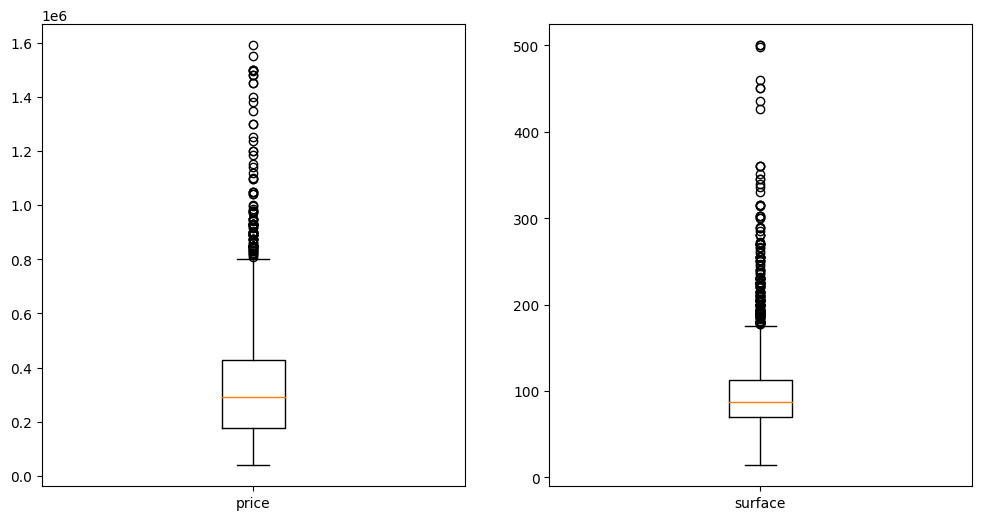

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,6))  # Set the size of the plot

ax[0].boxplot(casas_clean['price'], labels=['price']);

casas_clean =  casas_clean[casas_clean['surface'] <= 1000] # Eliminamos un valor extremo

ax[1].boxplot(casas_clean['surface'], labels=['surface']);

Podemos ver que en la variable objetivo hay varios outliers, vamos a dejarlos tal cual porque no creemos que eliminarlos sea correcto, pero se pueden hacer pruebas con y sin ellos y ver las diferencias.

# Variables Numéricas

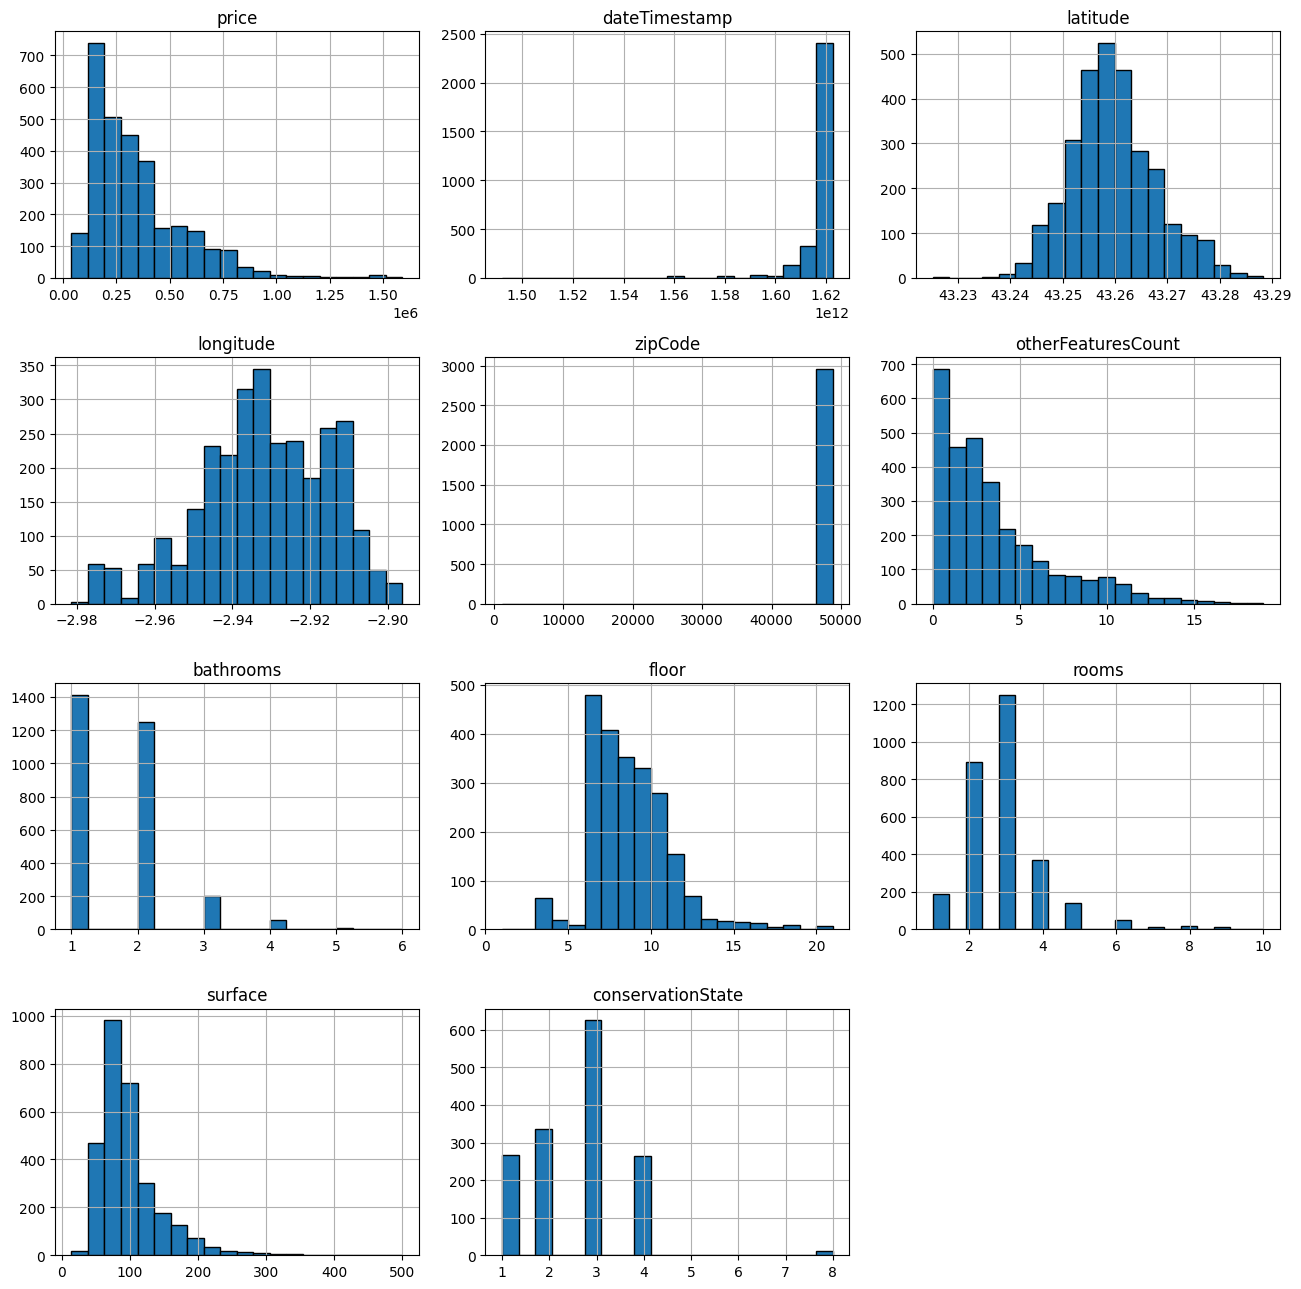

In [ ]:
numerical_cols = casas_clean.select_dtypes(include='number')
columnas_categoricas = ['elevator', 'balcony', 'terrace', 'heater', 'coordinatesAcc']
numerical_cols.drop(columns = columnas_categoricas, inplace=True)
casas_clean.loc[:,numerical_cols.columns].hist(bins=20, edgecolor='black', figsize=(13,13));
plt.tight_layout()
plt.show()

Podemos ver como en las variables dateTimestamp y zipCode la mayoría de valores se agrupan entorno a un número concreto. Con esto nos planteamos eliminar la variable zipCode. La variable dateTimestamp está codificada en un float para no tener la fecha en sí, así que también la eliminaremos. Por otro lado las variables de latitude y longitude parecen seguir una distribución mas cercana a una normal.

Veamos la matriz de correlacion de las variables

In [ ]:
corr_numericals = numerical_cols.corr()
corr_numericals.loc['price', corr_numericals.columns !=  'price'].sort_values(ascending=False)

surface               0.784133
bathrooms             0.723974
rooms                 0.528465
latitude              0.218783
otherFeaturesCount    0.130283
floor                 0.071897
dateTimestamp         0.038473
zipCode              -0.008821
conservationState    -0.063639
longitude            -0.109464
Name: price, dtype: float64

Podemos ver que tenemos varias variables que no tienen mucha correlación con la variable objetivo, así que se podrán eliminar en un futuro. A continuación  trataremos en el siguiente apartado las categóricas.

# Variables categóricas

### isHighlighted


precio medio no muy luminoso 336131.7375617167
precio medio muy luminoso 389736.87781350483


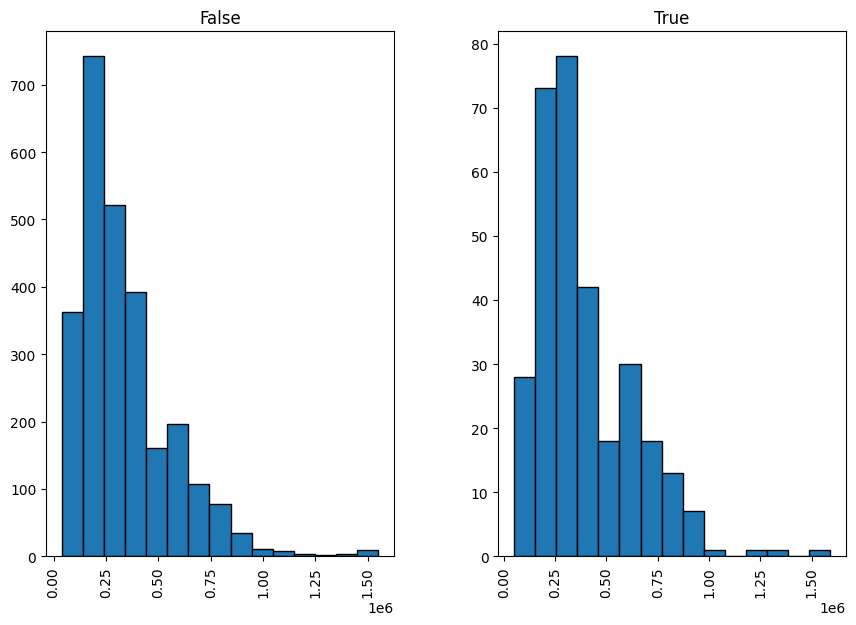

In [ ]:
casas_clean.hist(column='price',by='isHighlighted',bins=15, figsize=(10,7), edgecolor='black');
isHighlighted1 = casas_clean[casas_clean['isHighlighted'] == 0]['price'].mean()
isHighlighted2 = casas_clean[casas_clean['isHighlighted'] == 1]['price'].mean()
print()
print("precio medio no muy luminoso", isHighlighted1)
print("precio medio muy luminoso", isHighlighted2)

De media son algo más caras las casas highlighted.

### isNewConstruction


precio medio construcción antigua 341932.7144366197
precio medio construcción nueva 338020.4326923077


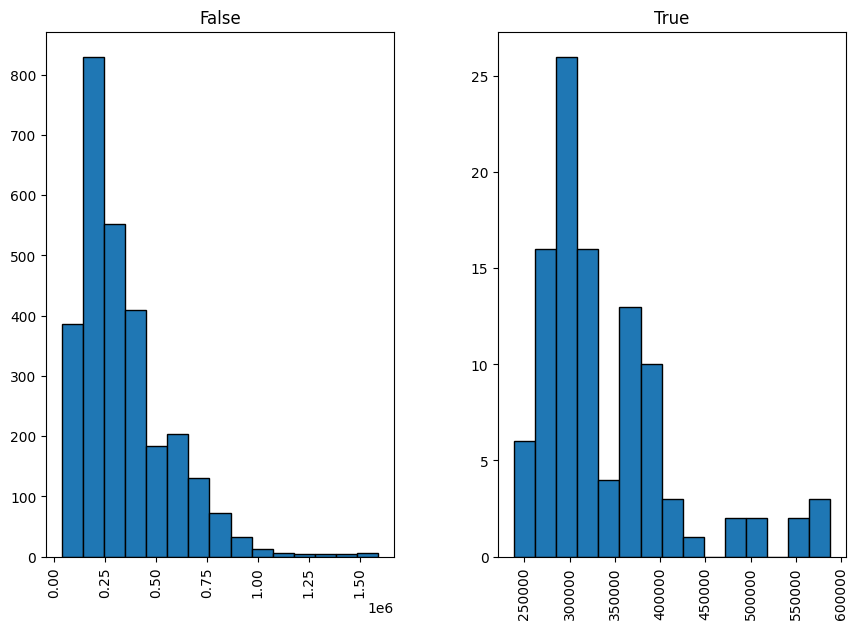

In [ ]:
casas_clean.hist(column='price',by='isNewConstruction',bins=15, figsize=(10,7), edgecolor='black');
isHighlighted1 = casas_clean[casas_clean['isNewConstruction'] == 0]['price'].mean()
isHighlighted2 = casas_clean[casas_clean['isNewConstruction'] == 1]['price'].mean()
print()
print("precio medio construcción antigua", isHighlighted1)
print("precio medio construcción nueva", isHighlighted2)


Parece que los precios de media son casi idénticos así que confirmamos lo valores vistos en el apartado anterior.

### isTop

precio medio no ático 342392.43124118476
precio medio ático 326093.50925925927


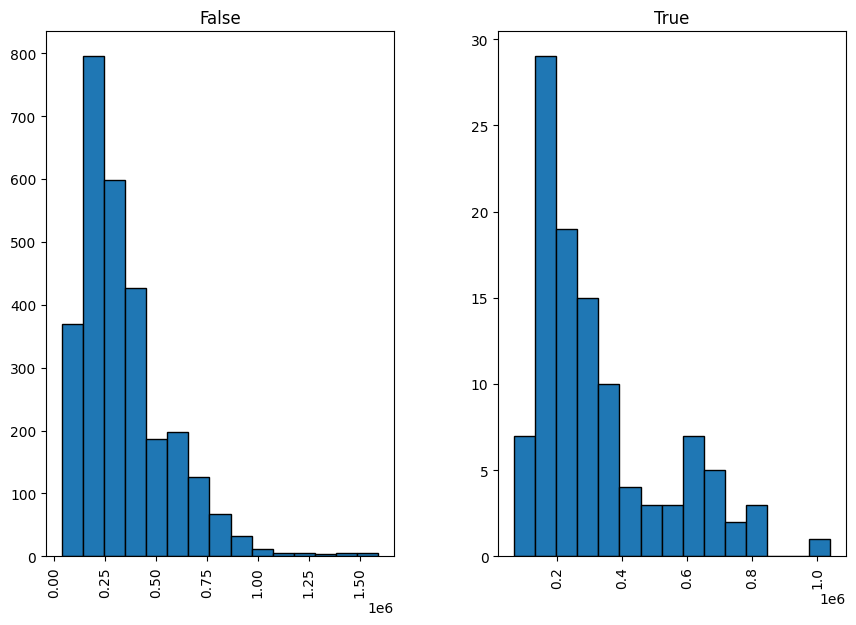

In [ ]:
casas_clean.hist(column='price',by='isTop',bins=15, figsize=(10,7), edgecolor='black');
isHighlighted1 = casas_clean[casas_clean['isTop'] == 0]['price'].mean()
isHighlighted2 = casas_clean[casas_clean['isTop'] == 1]['price'].mean()
print("precio medio no ático", isHighlighted1)
print("precio medio ático", isHighlighted2)

Podemos ver que el precio de media apenas cambia si estamos en un ático o no.

### isOpportunity


precio medio si no está de rebajas 343623.9357298475
precio medio si está de rebajas 315277.44736842107


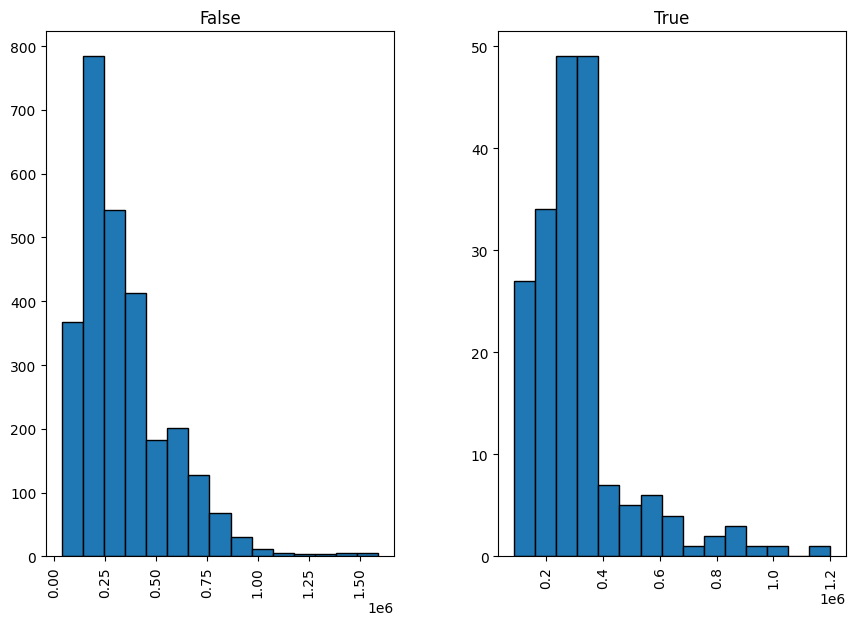

In [ ]:
casas_clean.hist(column='price',by='isOpportunity',bins=15, figsize=(10,7), edgecolor='black');
isHighlighted1 = casas_clean[casas_clean['isOpportunity'] == 0]['price'].mean()
isHighlighted2 = casas_clean[casas_clean['isOpportunity'] == 1]['price'].mean()
print()
print("precio medio si no está de rebajas", isHighlighted1)
print("precio medio si está de rebajas", isHighlighted2)

Podemos ver que si está de rebajas el precio es algo menor

### isMsAdvance


precio medio si no se paga por adelantado 342971.108658158
precio medio si se paga por adelantado 265995.3333333333


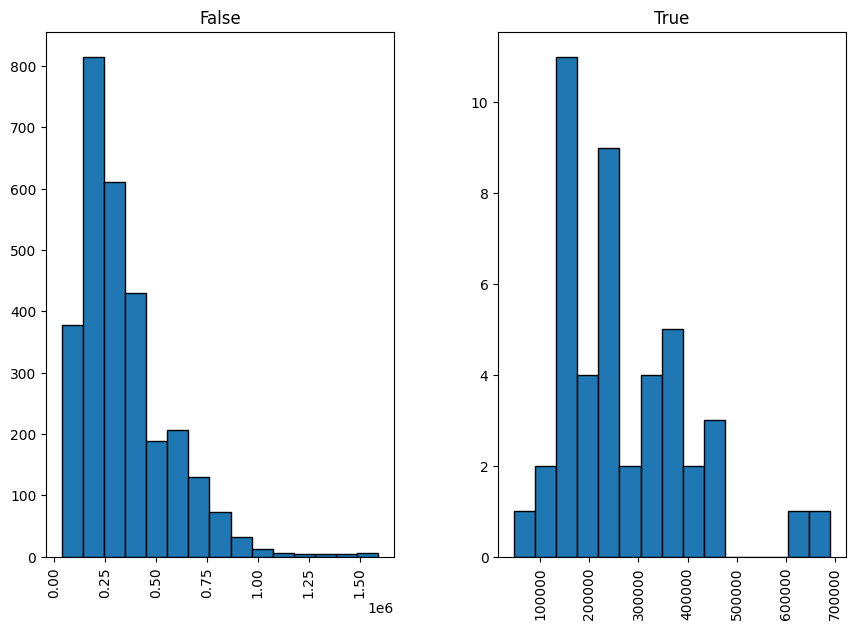

In [ ]:
casas_clean.hist(column='price',by='isMsAdvance',bins=15, figsize=(10,7), edgecolor='black');
isHighlighted1 = casas_clean[casas_clean['isMsAdvance'] == 0]['price'].mean()
isHighlighted2 = casas_clean[casas_clean['isMsAdvance'] == 1]['price'].mean()
print()
print("precio medio si no se paga por adelantado", isHighlighted1)
print("precio medio si se paga por adelantado", isHighlighted2)

Podemos observar que es bastante más barato de media si se paga por adelantado.

### isVirtualTour


precio medio si no tiene tour virtual 344189.914490161
precio medio si tiene tour virtual 296860.55704697984


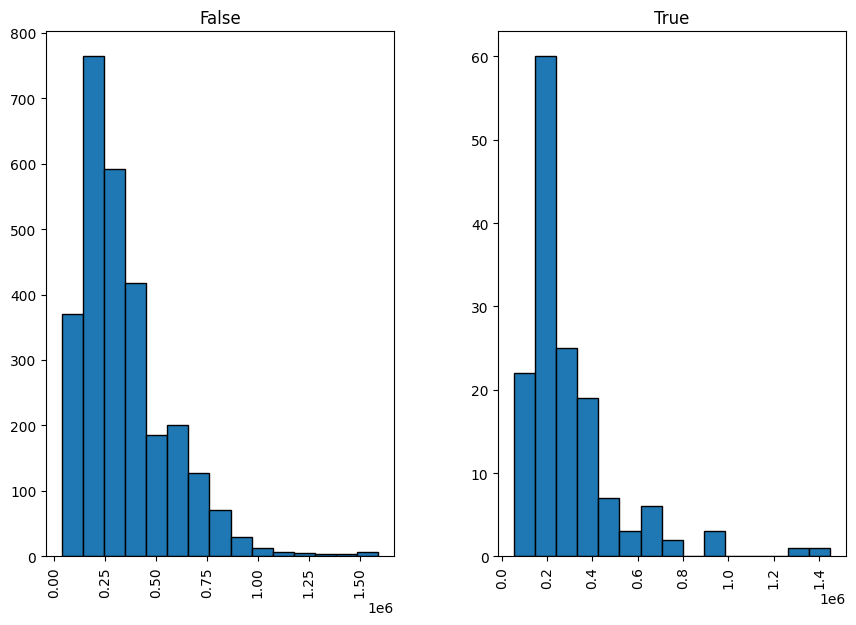

In [ ]:
casas_clean.hist(column='price',by='isVirtualTour',bins=15, figsize=(10,7), edgecolor='black');
isHighlighted1 = casas_clean[casas_clean['isVirtualTour'] == 0]['price'].mean()
isHighlighted2 = casas_clean[casas_clean['isVirtualTour'] == 1]['price'].mean()
print()
print("precio medio si no tiene tour virtual", isHighlighted1)
print("precio medio si tiene tour virtual", isHighlighted2)

Es algo más barato si no tiene tour virtual.

### coordinatesAcc


precio medio si coordinatesAcc es 0 347403.5952932099
precio medio si coordinatesAcc es 1 300491.23579545453


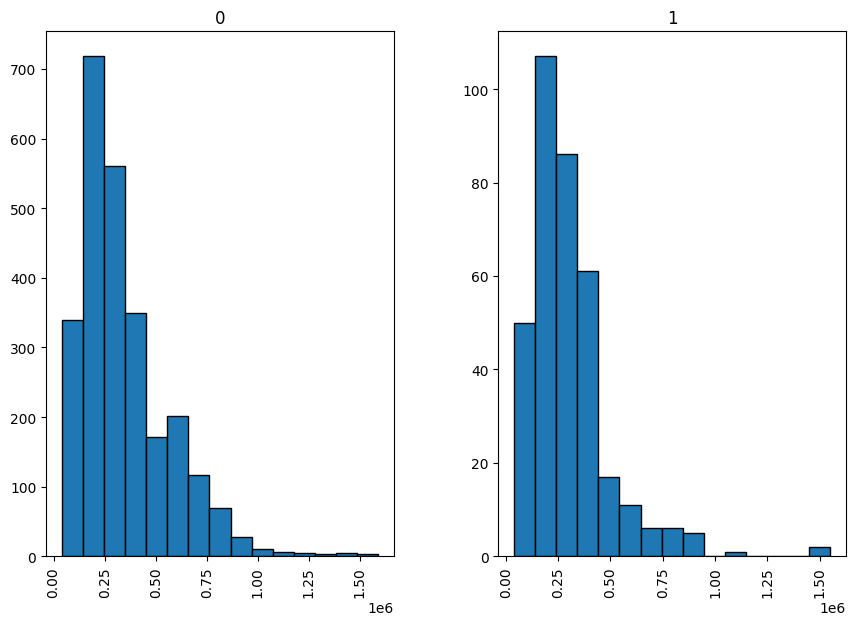

In [ ]:
casas_clean.hist(column='price',by='coordinatesAcc',bins=15, figsize=(10,7), edgecolor='black');
isHighlighted1 = casas_clean[casas_clean['coordinatesAcc'] == 0]['price'].mean()
isHighlighted2 = casas_clean[casas_clean['coordinatesAcc'] == 1]['price'].mean()
print()
print("precio medio si coordinatesAcc es 0", isHighlighted1)
print("precio medio si coordinatesAcc es 1", isHighlighted2)

Podemos ver que si coordinatesAcc es 1 es algo más barato de media.

### hasVgo


precio medio si hasVgo es 0 341820.60278627253
precio medio si hasVgo es 1 265000.0


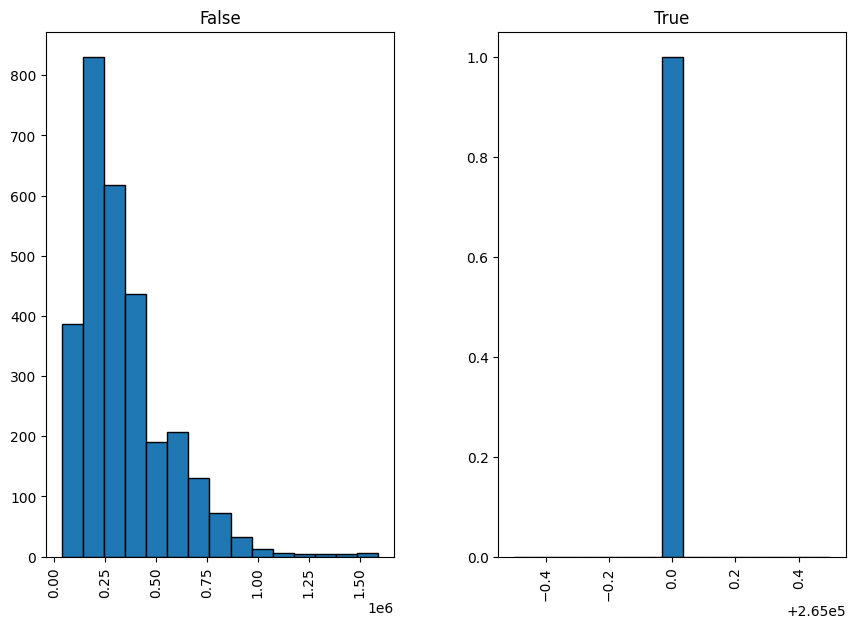

In [ ]:
casas_clean.hist(column='price',by='hasVgo',bins=15, figsize=(10,7), edgecolor='black');
isHighlighted1 = casas_clean[casas_clean['hasVgo'] == 0]['price'].mean()
isHighlighted2 = casas_clean[casas_clean['hasVgo'] == 1]['price'].mean()
print()
print("precio medio si hasVgo es 0", isHighlighted1)
print("precio medio si hasVgo es 1", isHighlighted2)

Podemos observar que solo hay un valor con hasVgo = True asi que eliminaremos esta variable del conjunto.

In [ ]:
len(casas_clean[casas_clean['hasVgo'] == True])

1

### buildingSubtype

Flat                     2786
Apartment                  52
Attic                      43
Duplex                     24
House_Chalet               19
SemidetachedHouse          16
Loft                        8
GroundFloorWithGarden       7
Study                       2
SemiDetached                1
Name: buildingSubtype, dtype: int64


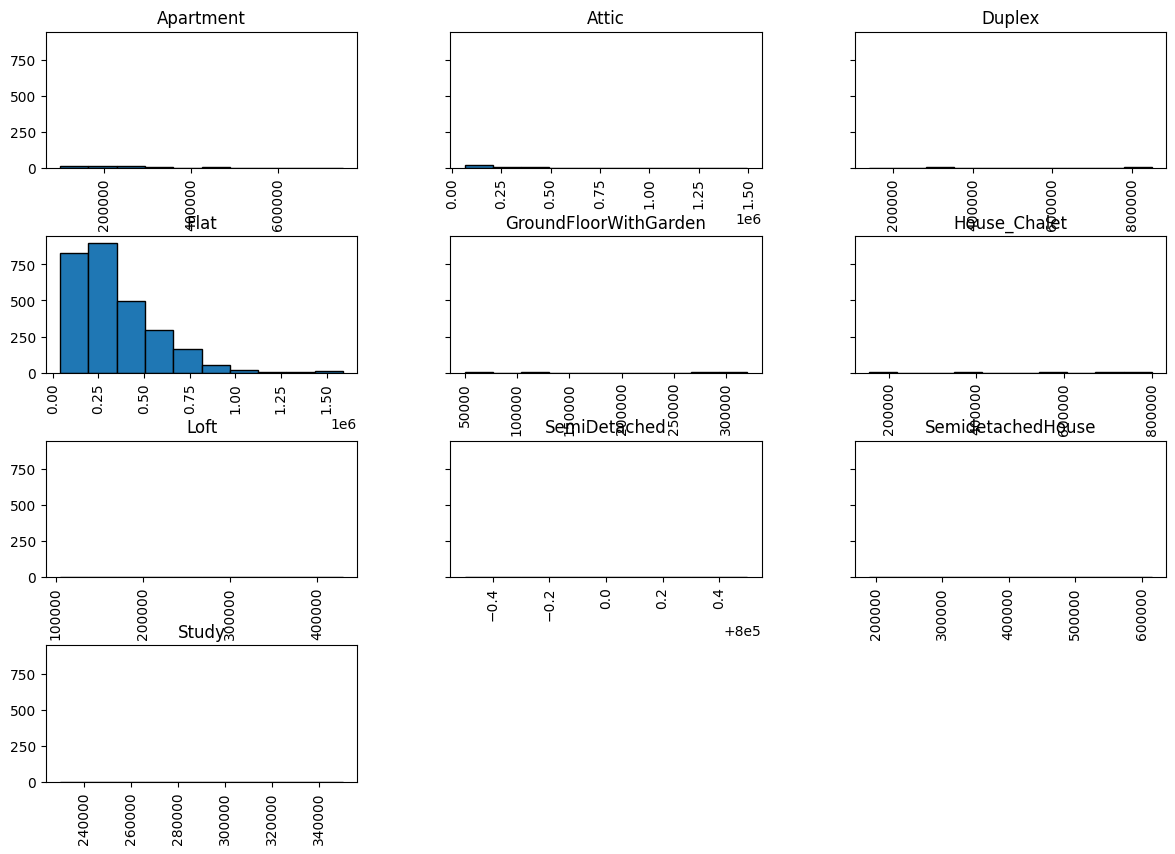

In [ ]:
print(casas_clean['buildingSubtype'].value_counts())

casas_clean.hist(column='price', by='buildingSubtype', sharey=True, figsize=(14,10), edgecolor='black');

Podemos ver que al ser una ciudad la mayoría de casas son de tipo piso, eliminaremos de este conjunto las variables con poca representación y aplicaremos un one-hot encoding al resto.

### District

Ibaiondo                   516
Begoña - Santutxu          470
Abando - Albia             437
Indautxu                   371
Errekalde                  288
Basurtu - Zorrotza         262
Uribarri                   257
Deusto                     250
Otxarkoaga - Txurdinaga    108
Name: district, dtype: int64


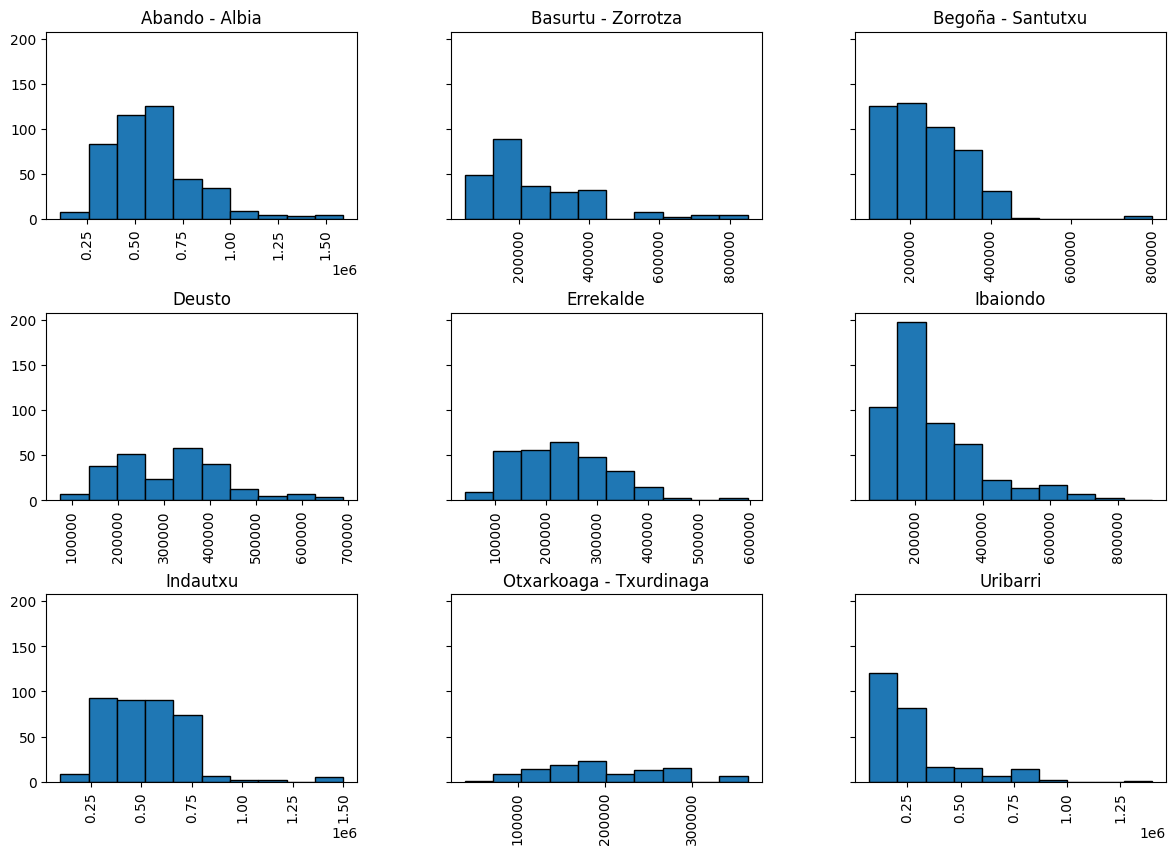

In [ ]:
print(casas_clean['district'].value_counts())

casas_clean.hist(column='price', by='district', sharey=True, figsize=(14,10), edgecolor='black');

Esta variable tendremos que convertirla usando un one-hot encoding. Podemos ver que hay barrios con mayor número de de viviendas, puede ser porque sean mas grandes y algunos con precios más caros.

### Neighborhood

Santutxu                           296
Casco Viejo                        144
Abandoibarra - Guggenheim          137
Bolueta                            130
San Pedro de Deusto - La Ribera    127
Ensanche - Moyua - Diputación      117
Sabino Arana - Jesuitas            115
Zona Indautxu                      114
Zorrotza                           103
Basurtu                             96
Ametzola                            90
Zabalburu                           89
Iralabarri                          89
Iturralde                           84
Barrio de Uribarri                  79
Campuzano                           75
Zurbaran                            72
Txurdinaga                          69
Alhóndiga                           66
San Francisco                       65
Castaños - Begoñaibarra             59
San Ignacio - Elorrieta             57
Rekalde Centro                      56
Zabala                              51
Albia                               48
Plaza Circular           

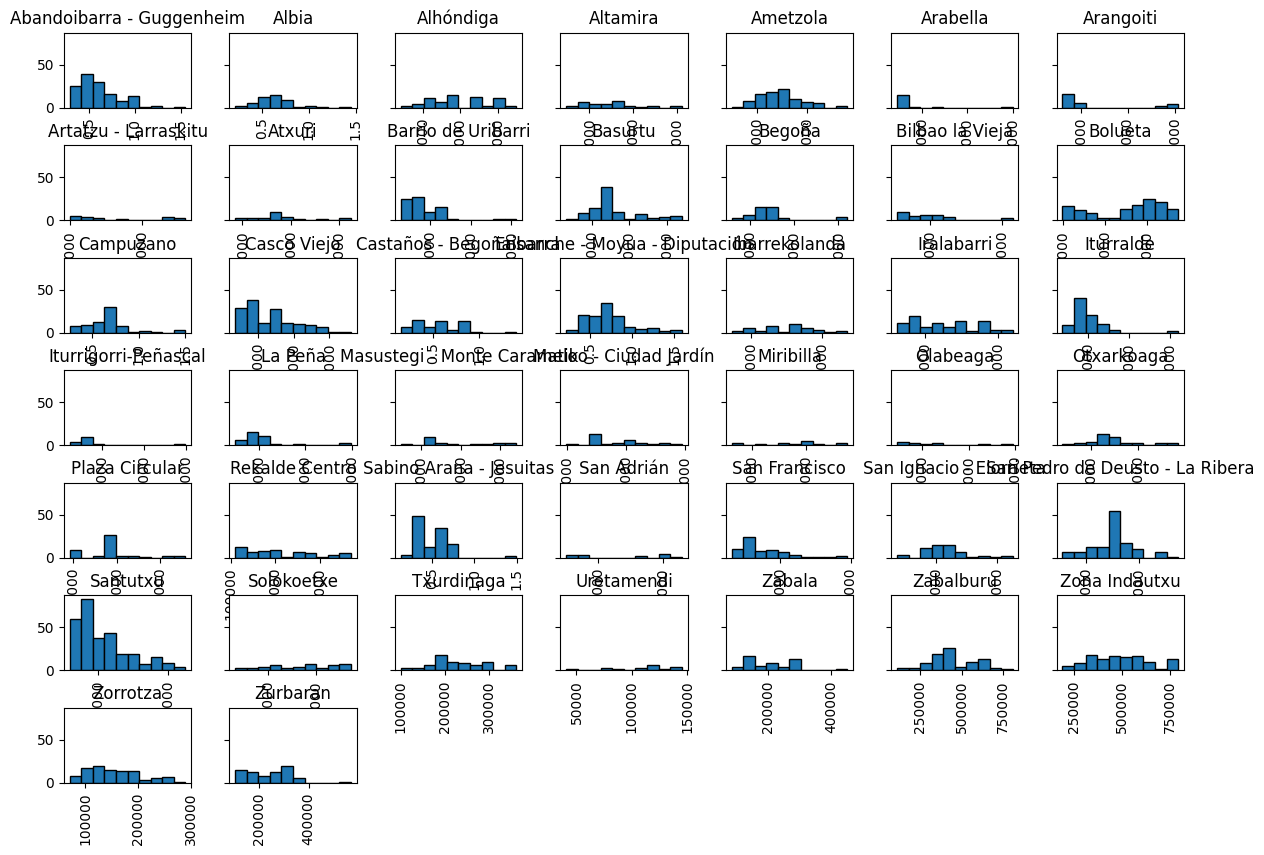

In [ ]:
print(casas_clean['neighborhood'].value_counts())

casas_clean.hist(column='price', by='neighborhood', sharey=True, figsize=(14,10), edgecolor='black');

Podemos ver que hay 44 barrios, no usaremos esta variable ya que con los distritos tendremos suficiente para la ubicación. Además el hecho de ser tantos no seria aceptable para usar un one-hot encoding.

## location

In [ ]:
print(casas_clean['location'].value_counts())

#casas_clean.hist(column='price', by='location', sharey=True, figsize=(14,10), edgecolor='black');

Ibaiondo                                     292
Abando - Albia                               221
Begoña - Santutxu                            196
Indautxu                                     187
Basurtu - Zorrotza                           148
                                            ... 
Máximo Aguirre Kalea, Indautxu                 1
Plaza Gordoniz, Errekalde                      1
Avenida de las Universidades, 2, Uribarri      1
Barrio Iturrigorri, Errekalde                  1
Navarro Villoslada Kalea, Deusto               1
Name: location, Length: 798, dtype: int64


Son datos muy parecidos a los de district pero añadiendo direccion personales asi que la vamos a eliminar también.

# upperLevel

Santutxu                           296
Casco Viejo                        144
Abandoibarra - Guggenheim          137
Bolueta                            130
San Pedro de Deusto - La Ribera    127
Ensanche - Moyua - Diputación      117
Sabino Arana - Jesuitas            115
Zona Indautxu                      114
Zorrotza                           103
Basurtu                             96
Ametzola                            90
Iralabarri                          89
Zabalburu                           89
Iturralde                           84
Barrio de Uribarri                  79
Campuzano                           75
Zurbaran                            72
Txurdinaga                          69
Alhóndiga                           66
San Francisco                       65
Castaños - Begoñaibarra             59
San Ignacio - Elorrieta             57
Rekalde Centro                      56
Zabala                              51
Albia                               48
Plaza Circular           

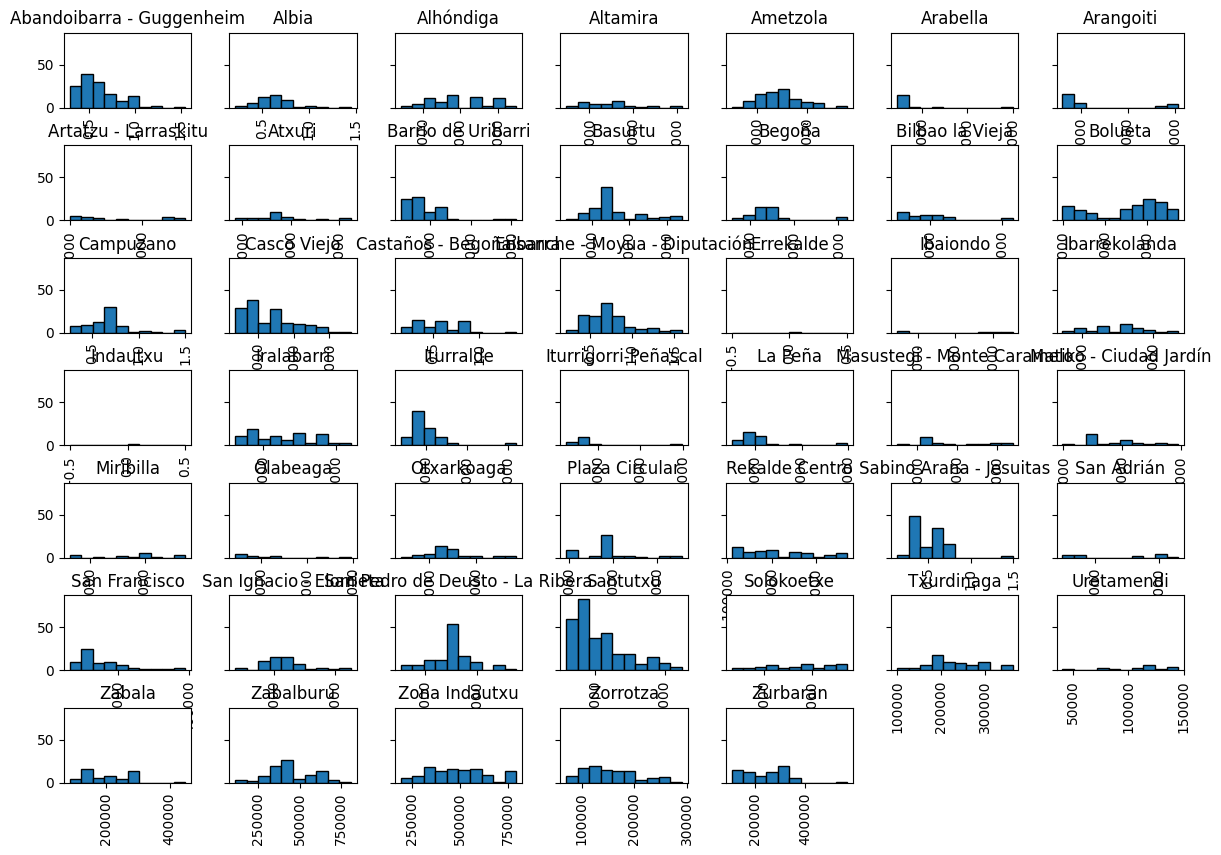

In [ ]:
print(casas_clean['upperLevel'].value_counts())

casas_clean.hist(column='price', by='upperLevel', sharey=True, figsize=(14,10), edgecolor='black');

Es exactamente los mismos datos que neighborhood asi que también los vamos a eliminar.

Ahora vamos a ver las 4 variables llenas de NaN si las llenamos con 0s

In [ ]:
casas_clean['terrace'].fillna(0, inplace=True)
casas_clean['elevator'].fillna(0, inplace=True)
casas_clean['balcony'].fillna(0, inplace=True)
casas_clean['heater'].fillna(0, inplace=True)

In [ ]:
casas_clean.isna().sum()

price                   15
dateTimestamp            0
coordinatesAcc           0
latitude                 0
longitude                0
district                 0
neighborhood             7
zipCode                  0
upperLevel               0
buildingSubtype          1
hasVgo                   0
isHighlighted            0
isMsAdvance              0
isNewConstruction        0
isOpportunity            0
isTop                    0
isVirtualTour            0
location                 0
otherFeaturesCount       0
bathrooms               25
floor                  701
elevator                 0
balcony                  0
rooms                   16
surface                  0
terrace                  0
heater                   0
conservationState     1456
dtype: int64

Podemos ver que hay un gran número de valores perdidos en las variables floor y conservationState, vamos a eliminar dichas variables para no reducir significativamente el número de datos en el preprocesado.

### Terrace


precio medio si no tiene terraza 340086.3630406291
precio medio si tiene terraza 347763.89160305343


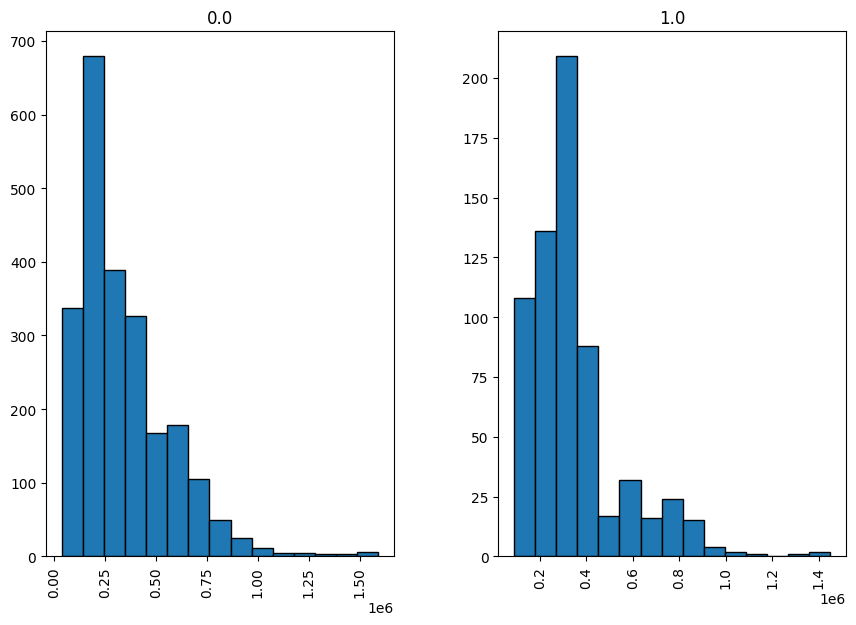

In [ ]:
casas_clean.hist(column='price',by='terrace',bins=15, figsize=(10,7), edgecolor='black');
isHighlighted1 = casas_clean[casas_clean['terrace'] == 0]['price'].mean()
isHighlighted2 = casas_clean[casas_clean['terrace'] == 1]['price'].mean()
print()
print("precio medio si no tiene terraza", isHighlighted1)
print("precio medio si tiene terraza", isHighlighted2)

Parece que el precio no cambia mucho si tiene terraza

### Elevator


precio medio si no tiene ascensor 247604.30012150668
precio medio si tiene ascensor 378342.61904761905


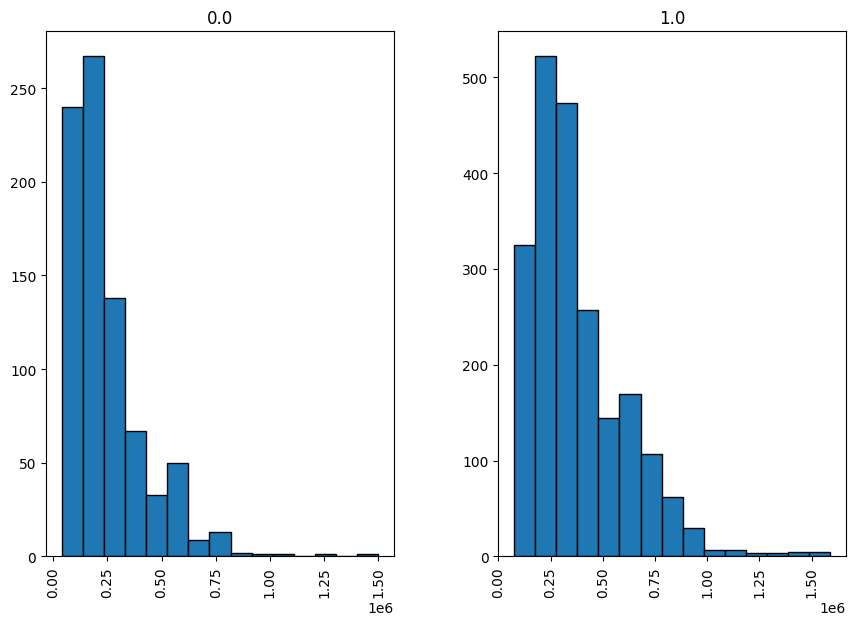

In [ ]:
casas_clean.hist(column='price',by='elevator',bins=15, figsize=(10,7), edgecolor='black');
isHighlighted1 = casas_clean[casas_clean['elevator'] == 0]['price'].mean()
isHighlighted2 = casas_clean[casas_clean['elevator'] == 1]['price'].mean()
print()
print("precio medio si no tiene ascensor", isHighlighted1)
print("precio medio si tiene ascensor", isHighlighted2)

Podemos ver que los pisos con ascensor son bastante más caros.

### Balcony


precio medio si no tiene balcon 330783.5362694301
precio medio si tiene balcon 382401.85350318474


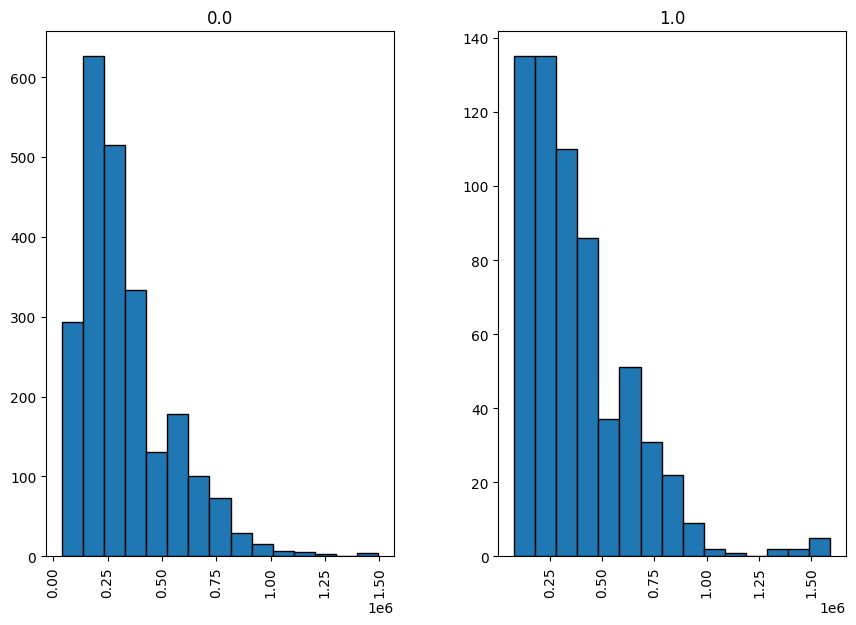

In [ ]:
casas_clean.hist(column='price',by='balcony',bins=15, figsize=(10,7), edgecolor='black');
isHighlighted1 = casas_clean[casas_clean['balcony'] == 0]['price'].mean()
isHighlighted2 = casas_clean[casas_clean['balcony'] == 1]['price'].mean()
print()
print("precio medio si no tiene balcon", isHighlighted1)
print("precio medio si tiene balcon", isHighlighted2)

Son más caras las casas con balcón.

### Heater


precio medio si no tiene calefacción 307695.3714524207
precio medio si tiene calefacción 365191.2823596793


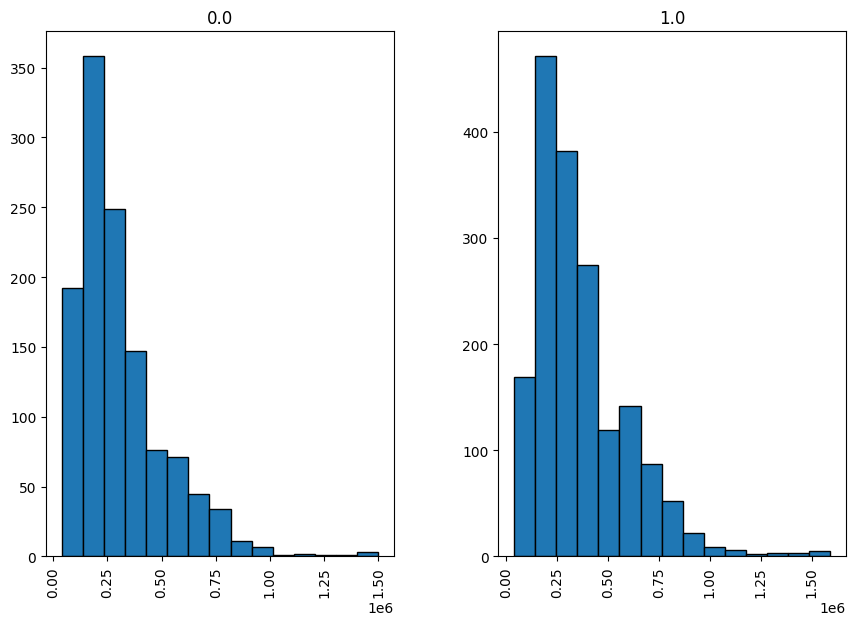

In [ ]:
casas_clean.hist(column='price',by='heater',bins=15, figsize=(10,7), edgecolor='black');
isHighlighted1 = casas_clean[casas_clean['heater'] == 0]['price'].mean()
isHighlighted2 = casas_clean[casas_clean['heater'] == 1]['price'].mean()
print()
print("precio medio si no tiene calefacción", isHighlighted1)
print("precio medio si tiene calefacción", isHighlighted2)

Las casas con calefacción son más caras de media.

Ahora que hemos corregido las variables con NaN veamos el heatmap

<Axes: >

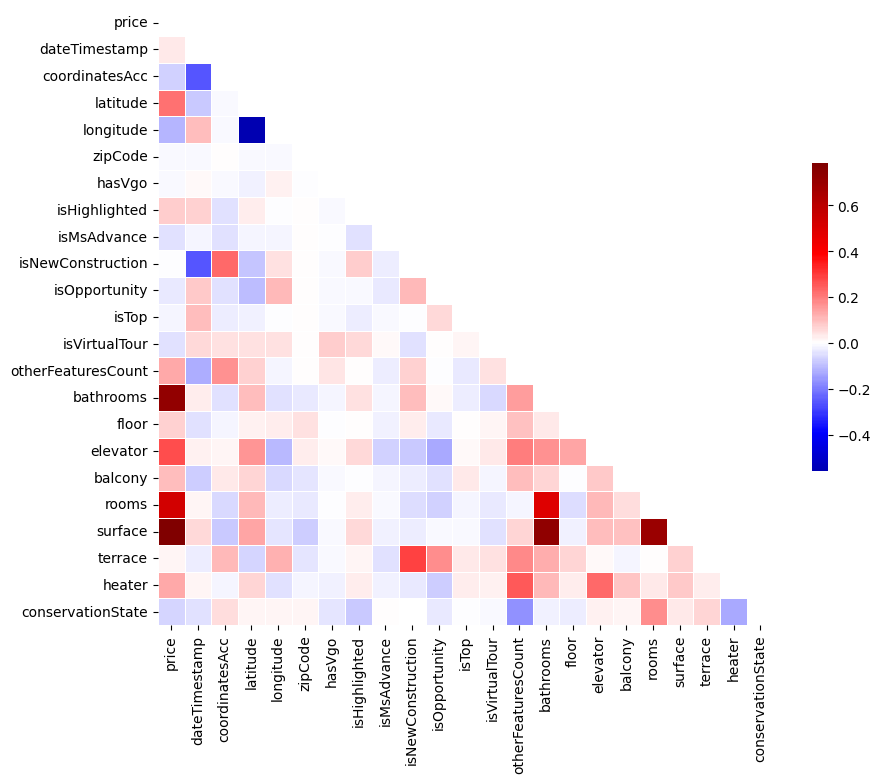

In [ ]:
corr_numericals = casas_clean.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr_numericals, dtype=bool))
plt.subplots(figsize=(10, 8))
sns.heatmap(corr_numericals, mask=mask, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
#corr_numericals.loc['price', corr_numericals.columns !=  'price'].sort_values(ascending=False)

Podemos ver que zipCode no tiene mucha relación, esto con lo ya mencionado anteriormente nos lleva a quitar la variable.

# Preprocesado

In [ ]:
def preprocessing(X, y):
    print('Tamaño antes de preprocesado:{}'.format(X.shape))
    #Cambiamos true/false por 1, 0
    columns_TF = ['isVirtualTour', 'isMsAdvance', 'isOpportunity', 'isTop', 'isNewConstruction', 'isHighlighted']
    X.loc[:, columns_TF] = X.loc[:, columns_TF].replace([True, False], [1, 0])


    # Cambiamos el nombre a variables
    X.rename({'isMsAdvance': 'isPayedAdvance', 'coordinatesAcc': 'hasCoordinates', 'Terrace': 'hasTerrace', 'Balcony': 'hasBalcony', 'Heater': 'hasHeater', 'Elevator': 'hasElevator', 'isVirtualTour' : 'hasVirtualTour'}, axis=1, inplace=True)

    X = X[~X['buildingSubtype'].isin(['House_Chalet', 'SemidetachedHouse', 'Loft', 'GroundFloorWithGarden', 'Study', 'SemiDetached'])]

    district_dummies =  pd.get_dummies(X['district'], prefix='district', drop_first=True)
    buildingSubtype_dummies = pd.get_dummies(X['buildingSubtype'], prefix='buildingSubtype', drop_first=True)
    X = pd.concat([X, district_dummies, buildingSubtype_dummies], axis=1)

    #Eliminamos variables
    X.drop(columns=['hasVgo','zipCode', 'dateTimestamp', 'neighborhood', 'upperLevel', 'location', 'district', 'buildingSubtype', 'conservationState', 'floor'], inplace=True)

    #Eliminamos valores perdidos
    X=X.dropna()
    y=y[X.index]

    print('Tamaño despues de preprocesado:{}'.format(X.shape))
    return X, y

In [ ]:
from sklearn.model_selection import train_test_split

casas_clean = casas_clean.dropna(subset=['price'])
X = casas_clean.loc[:,casas_clean.columns != 'price']
y = casas_clean['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # Dividimos todos los datos en 70% para entrenar y 30% para test
casas_clean.isna().sum()

price                    0
dateTimestamp            0
coordinatesAcc           0
latitude                 0
longitude                0
district                 0
neighborhood             7
zipCode                  0
upperLevel               0
buildingSubtype          1
hasVgo                   0
isHighlighted            0
isMsAdvance              0
isNewConstruction        0
isOpportunity            0
isTop                    0
isVirtualTour            0
location                 0
otherFeaturesCount       0
bathrooms               25
floor                  698
elevator                 0
balcony                  0
rooms                   16
surface                  0
terrace                  0
heater                   0
conservationState     1447
dtype: int64

In [ ]:
X_train, y_train = preprocessing(X_train,y_train)
print()
X_test, y_test = preprocessing(X_test,y_test)

Tamaño antes de preprocesado:(2060, 27)
Tamaño despues de preprocesado:(2012, 28)

Tamaño antes de preprocesado:(884, 27)
Tamaño despues de preprocesado:(855, 28)


In [ ]:
X_train.head()

,hasCoordinates,latitude,longitude,isHighlighted,isPayedAdvance,isNewConstruction,isOpportunity,isTop,hasVirtualTour,otherFeaturesCount,...,district_Begoña - Santutxu,district_Deusto,district_Errekalde,district_Ibaiondo,district_Indautxu,district_Otxarkoaga - Txurdinaga,district_Uribarri,buildingSubtype_Attic,buildingSubtype_Duplex,buildingSubtype_Flat
128,0,43.26369,-2.945354,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1321,0,43.26046,-2.957517,0,0,0,1,0,0,11,...,0,0,0,0,0,0,0,0,0,1
1751,0,43.26855,-2.923679,0,0,0,0,0,0,4,...,0,0,0,0,0,0,1,0,0,1
1376,0,43.27416,-2.947817,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
625,1,43.25774,-2.917870,0,0,0,0,0,0,11,...,0,0,0,1,0,0,0,0,0,1


Primero vamos a estandarizar los datos para poder realizar el PCA y las futuras predicciones.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_s = X_train.copy()
X_test_s = X_test.copy()

X_train_s[X_train_s.columns] = scaler.fit_transform(X_train_s[X_train_s.columns])
X_test_s[X_test_s.columns] = scaler.transform(X_test_s[X_test_s.columns])

X_train_s

,hasCoordinates,latitude,longitude,isHighlighted,isPayedAdvance,isNewConstruction,isOpportunity,isTop,hasVirtualTour,otherFeaturesCount,...,district_Begoña - Santutxu,district_Deusto,district_Errekalde,district_Ibaiondo,district_Indautxu,district_Otxarkoaga - Txurdinaga,district_Uribarri,buildingSubtype_Attic,buildingSubtype_Duplex,buildingSubtype_Flat
128,-0.370629,0.510410,-0.828764,2.854024,-0.125095,-0.1856,-0.262822,-0.198132,-0.221381,-0.941948,...,-0.423517,-0.295918,-0.327597,-0.470760,-0.388625,-0.195406,-0.312497,-0.116628,-0.092311,0.20481
1321,-0.370629,0.095456,-1.560953,-0.350382,-0.125095,-0.1856,3.804855,-0.198132,-0.221381,2.308315,...,-0.423517,-0.295918,-0.327597,-0.470760,-0.388625,-0.195406,-0.312497,-0.116628,-0.092311,0.20481
1751,-0.370629,1.134768,0.476028,-0.350382,-0.125095,-0.1856,-0.262822,-0.198132,-0.221381,0.239966,...,-0.423517,-0.295918,-0.327597,-0.470760,-0.388625,-0.195406,3.200035,-0.116628,-0.092311,0.20481
1376,-0.370629,1.855477,-0.977032,-0.350382,-0.125095,-0.1856,-0.262822,-0.198132,4.517107,-0.941948,...,-0.423517,3.379313,-0.327597,-0.470760,-0.388625,-0.195406,-0.312497,-0.116628,-0.092311,0.20481
625,2.698117,-0.253979,0.825719,-0.350382,-0.125095,-0.1856,-0.262822,-0.198132,-0.221381,2.308315,...,-0.423517,-0.295918,-0.327597,2.124224,-0.388625,-0.195406,-0.312497,-0.116628,-0.092311,0.20481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2186,-0.370629,-0.316928,0.859309,2.854024,-0.125095,-0.1856,-0.262822,-0.198132,-0.221381,0.830923,...,-0.423517,-0.295918,-0.327597,2.124224,-0.388625,-0.195406,-0.312497,-0.116628,-0.092311,0.20481
1653,-0.370629,-1.632448,1.465443,-0.350382,-0.125095,-0.1856,3.804855,-0.198132,-0.221381,-0.350991,...,2.361178,-0.295918,-0.327597,-0.470760,-0.388625,-0.195406,-0.312497,-0.116628,-0.092311,0.20481
1142,-0.370629,-0.070268,-0.203487,-0.350382,-0.125095,-0.1856,-0.262822,-0.198132,-0.221381,-0.646469,...,-0.423517,-0.295918,-0.327597,-0.470760,2.573172,-0.195406,-0.312497,-0.116628,-0.092311,0.20481
1306,2.698117,-1.126281,1.112863,-0.350382,-0.125095,-0.1856,-0.262822,-0.198132,-0.221381,2.308315,...,2.361178,-0.295918,-0.327597,-0.470760,-0.388625,-0.195406,-0.312497,-0.116628,-0.092311,0.20481


# PCA

In [ ]:
myPCA = PCA().fit(X_train_s);

print(myPCA.explained_variance_ratio_)
print(myPCA.explained_variance_ratio_.cumsum())

[0.10736121 0.08215603 0.06484929 0.06398848 0.05308674 0.05046364
 0.04586601 0.04219555 0.0406528  0.03986702 0.03854893 0.037181
 0.03567052 0.03426467 0.03376557 0.03160168 0.03111135 0.0286244
 0.02565805 0.02457966 0.02360693 0.02061697 0.01542481 0.00953014
 0.00742575 0.0058489  0.00401979 0.00203411]
[0.10736121 0.18951723 0.25436653 0.31835501 0.37144175 0.42190539
 0.4677714  0.50996696 0.55061975 0.59048677 0.62903571 0.66621671
 0.70188723 0.7361519  0.76991747 0.80151914 0.83263049 0.86125489
 0.88691294 0.91149259 0.93509953 0.9557165  0.97114131 0.98067145
 0.9880972  0.9939461  0.99796589 1.        ]


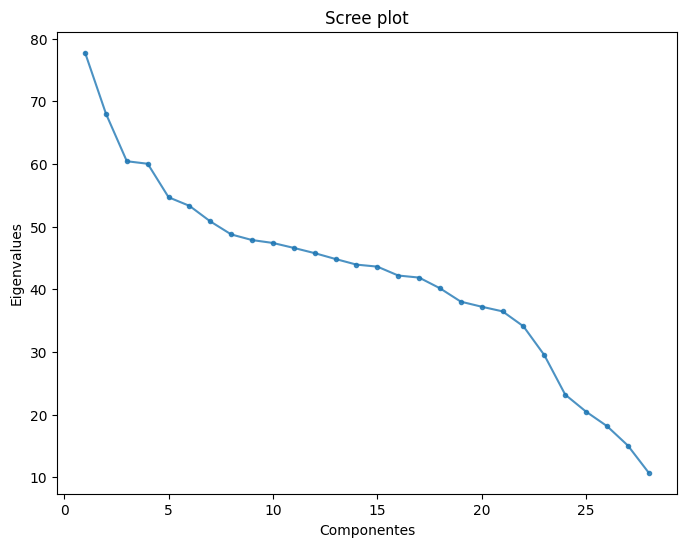

In [ ]:
fig = plt.figure(figsize=(8,6));
plt.plot(range(1,len(myPCA.singular_values_ )+1),myPCA.singular_values_ ,alpha=0.8,marker='.');
y_label = plt.ylabel('Eigenvalues');
x_label = plt.xlabel('Componentes');
plt.title('Scree plot');

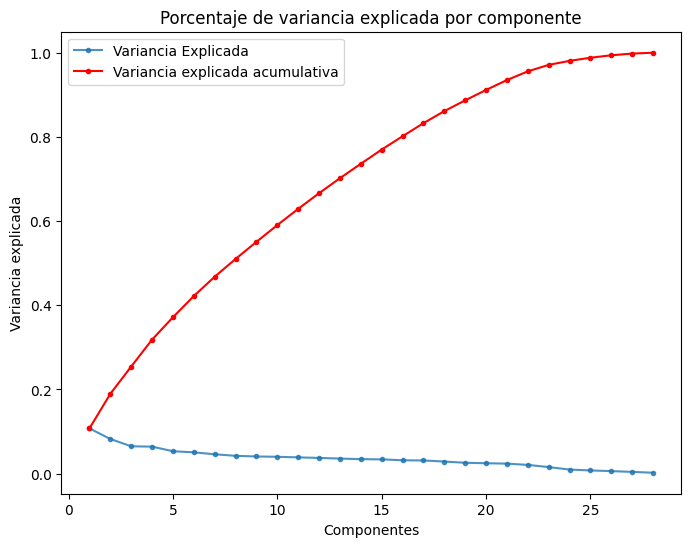

In [ ]:
fig = plt.figure(figsize=(8,6));
plt.plot(range(1,len(myPCA.explained_variance_ratio_ )+1),myPCA.explained_variance_ratio_ ,alpha=0.8,marker='.',label="Variancia Explicada");
y_label = plt.ylabel('Variancia explicada');
x_label = plt.xlabel('Componentes');
plt.plot(range(1,len(myPCA.explained_variance_ratio_ )+1),
         np.cumsum(myPCA.explained_variance_ratio_),
         c='red',marker='.',
         label="Variancia explicada acumulativa");
plt.legend();
plt.title('Porcentaje de variancia explicada por componente');

Podemos ver que necesitamos 16 componentes para explicar más del 80% de la varianza.

Con los primeros dos componentes tan solo podemos explicar algo menos del 20% del modelo, aún así vamos a intentar visualizar los datos a ver si podemos obtener algo de información.

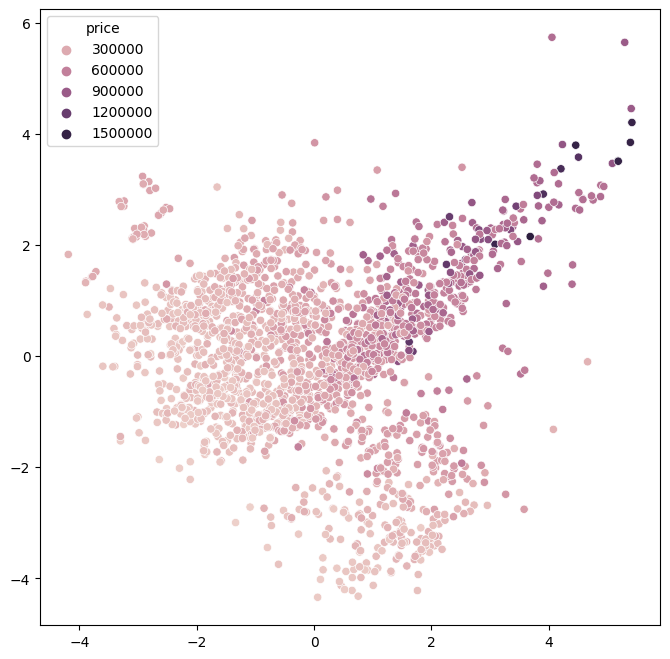

In [ ]:
X_train_trans = myPCA.transform(X_train_s)
plt.figure(figsize=(8,8));
sns.scatterplot(x=X_train_trans[:,0], y=X_train_trans[:,1], hue=y_train);

Podemos ver un gran número de casas con coste bajo, agrupadas entorno al mismo sitio junto con aquellas con un coste algo más grande. Luego tenemos unas pocas con un coste mucho mayor que están alejadas.

# Guardar modelos
Vamos a hacer una función para guardar los modelos y que sea más sencillo compararlos posteriormente.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

def save_results(clf, nclf, X, y, df):
    df.loc[nclf,'test_score'] = clf.score(X, y)
    if (nclf != "Lasso CV"):
        df.loc[nclf,'cross_val_score'] = clf.best_score_
    else:
        df.loc[nclf,'cross_val_score'] = np.mean(cross_val_score(clf, X, y))
    return df

results_df = pd.DataFrame()
cv = 10


## Regresión Lineal

Utilizaremos dentro de los modelos lineales o cuadráticos la regresión LASSO, la regresión de KNeighbors, la SVM con kernel lineal y polinómico.

### LASSOCV

Vamos a empezar con el modelo Lasso, vamos a añadir regularizacion para ver si el rendimiento de nuestro modelo mejoran. Usaremos regresión LASSO con validación cruzada (CV) de la librería sklearn.

In [ ]:
from sklearn.linear_model import LassoCV
lambdas = [1e-7,1e-4,1e-3,1e-2,0.1, 0.5,1,5,10,50,60, 65, 80, 90, 100, 150, 160, 200, 300, 500, 600, 800, 1000] # Alpha es el parámetro de regularización que controla la intensidad de la penalización L1

modelo_lasso_cv = LassoCV(alphas=lambdas,cv=cv)
modelo_lasso_cv.fit(X_train_s,y_train)

lasso_r2 =  np.mean(cross_val_score(modelo_lasso_cv, X_train_s, y_train))

print("Mejor lambda: ", modelo_lasso_cv.alpha_)
print("R2 Score: ", lasso_r2)
print("Coeficientes: ", modelo_lasso_cv.coef_)


Mejor lambda:  50.0
R2 Score:  0.8172773376505574
Coeficientes:  [  -905.7358109   17437.41165533  23098.40430327   2455.12246237
  -1810.47929923   5637.53381538  -1472.31814789  -3111.63825917
  -2108.3222189    8752.570365    45653.91618061  11040.51528258
   2987.92563416 -23839.10980619 121791.22051024  -3330.01948634
   3308.92413741 -37550.08820236 -62971.61172927 -33883.15128032
 -41140.09060572 -70059.44654005  -3672.86103988 -43628.07168263
 -52914.21891185   1670.25447076   6490.75386067   1975.58737382]


Podemos ver que la mejor lambda ha sido con el valor 50, obtenemos una R2 Score del 0.817 en el entreno que está bastante bien, vamos a comparar los resultados con el test y ver que obtenemos.

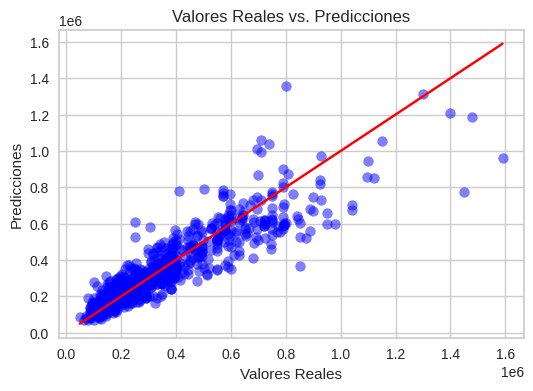

0.8060387366845838

In [ ]:
# Predecimos con el método predict
y_pred = modelo_lasso_cv.predict(X_test_s)
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')  # Puntos de predicción
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Línea de predicción perfecta
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Valores Reales vs. Predicciones')
plt.show()

r2_score(y_test, y_pred)

In [ ]:
results_df = save_results(modelo_lasso_cv, 'Lasso CV', X_test_s, y_test, results_df)
results_df.sort_values(by='test_score', ascending=False)

,test_score,cross_val_score
Lasso CV,0.806039,0.794793


Podemos ver que obtenemos una R2 score en el test de 0.806, muy parecida al valor del train, esto nos indica que no ha habido overfitting y el modelo ha aprendido correctamente de los valores de train para generalizarlos al test.

En la figura vemos como las predicciones se adaptan correctamente a los valores reales a excepción de algunos puntos, sobretodo aquellos valores extremos donde tenemos menos datos, los valores del 0 al 0.8 se predicen de manera bastante correcta.

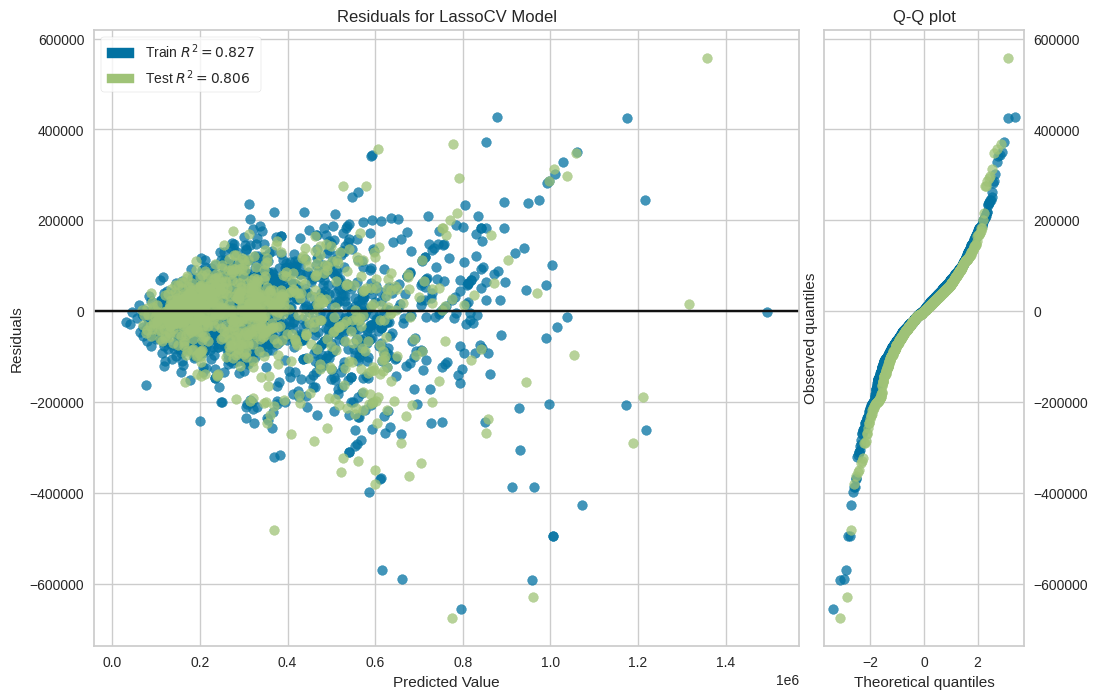

In [ ]:
from yellowbrick.regressor import residuals_plot
plt.figure(figsize=(12,8));
viz = residuals_plot(modelo_lasso_cv, X_train_s, y_train, X_test_s, y_test, is_fitted=True, qqplot=True, hist=False)

Podemos ver el plot de los residuos como en Train y Test no tienen valores muy diferentes, siguen la tendencia de que los valores más altos se predicen peor que los más bajos.

Vamos a ver la importancia de los diferentes atributos para luego poder compararla con los demás modelos.

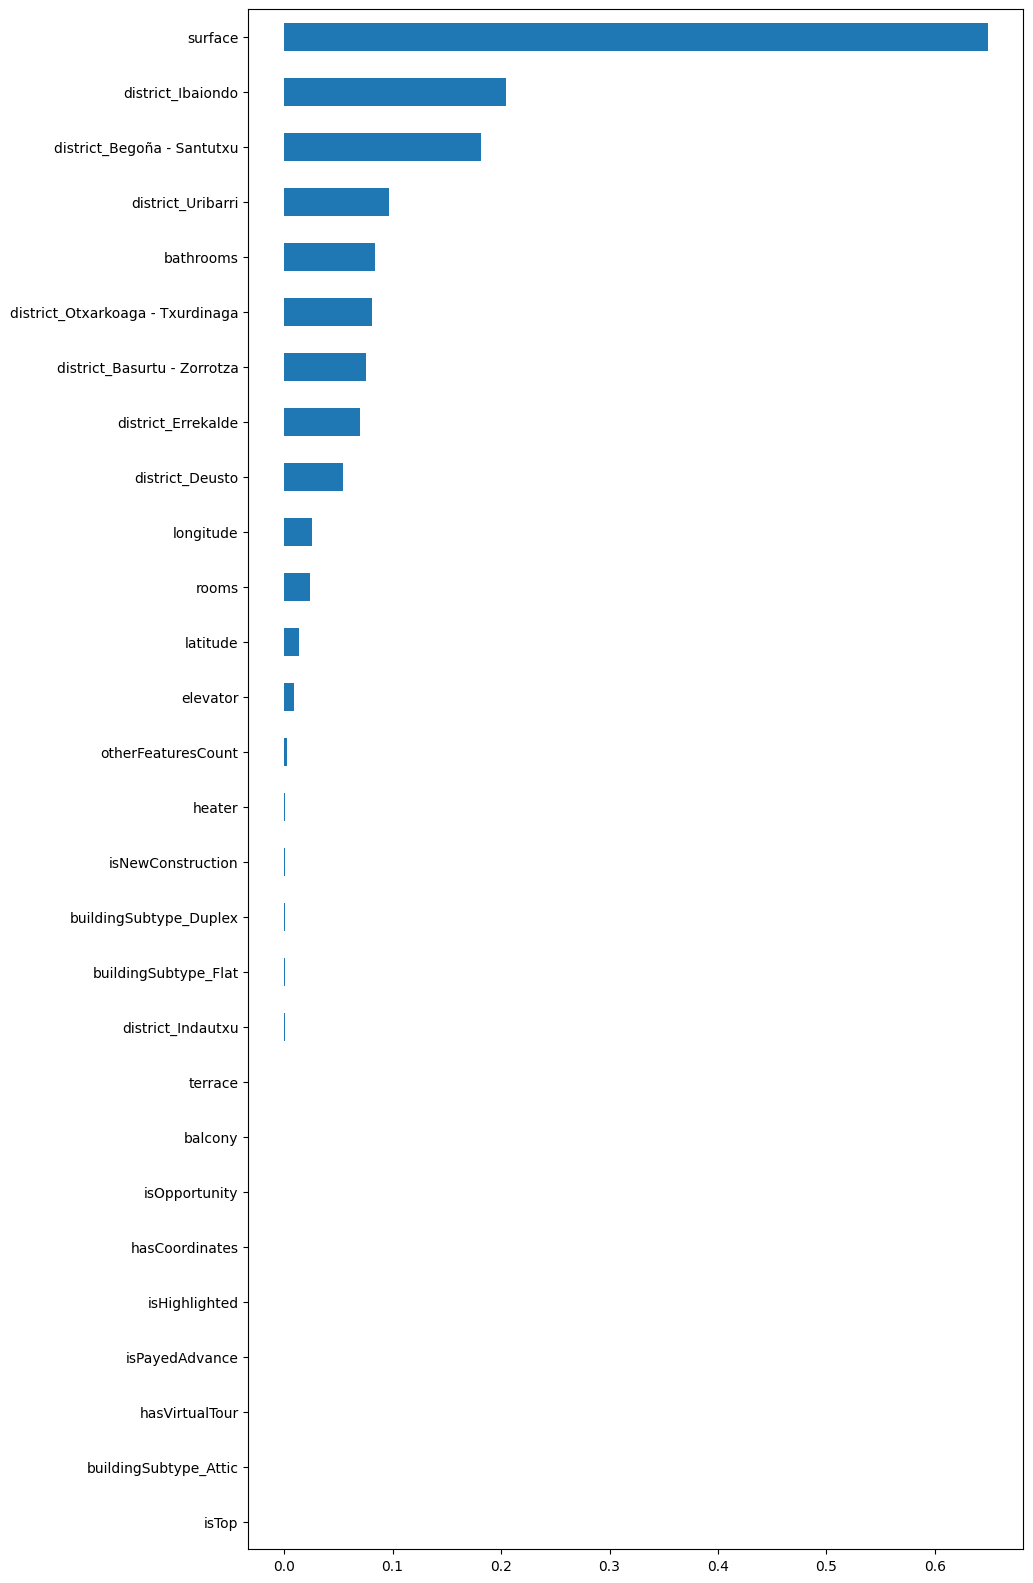

In [ ]:
from sklearn.inspection import permutation_importance
from numpy.random import choice

c = choice(X_test_s.shape[0], size=X_test_s.shape[0], replace=False)
pi = permutation_importance(modelo_lasso_cv, X_test_s.iloc[c,:], y_test.to_numpy()[c], n_jobs=-1, random_state=14)
var_imp_lasso_cv = pd.DataFrame({'importance': pi.importances_mean}, index=X_test_s.columns)

var_imp_lasso_cv.sort_values(by='importance').plot.barh(figsize=(10,20), legend=False);

Podemos ver como la variable más importante con diferencia es surface, seguida de distrito Ibaiondo. Tiene sentido que el precio esté muy relacionado con la superfície del piso.

### K-neighbors más cercanos

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
modelo_knn = KNeighborsRegressor()

# El modelo K-Nearest Neighbors en Scikit-learn tiene varios parametros que se pueden ajustar y probar para mejorar el rendimiento del modelo:
#
# n_neighbors: numero de vecions a considerar y a menudo se eligen valores impare para evitar empates
# weights: funcion de peso utilizada en la predicción ("uniform" todos los vecinos tienen el mismo peso y "distance" tienen un mayor peso los vecinos más cercanos) se puede usar una funcion definida por el usuario
# algorithm: algoritmo para calcular los vecions más cercanos (tiene una opcion automatica que intentara predecir cual es el algoritmo más apropiado basado en los valores de entrenamiento)
# leaf_size: tamaño de la hoja pasado al BallTree o KDtree (algoritmos que se pueden usar para calcular los vecinos)
# metric: métrica de distancia a utilizar para el árbol (los valores típicos son la distancia euclidean, manhattan, minkowski o tambien se puede usar una funcion definida por el usuario)

parametros = {
    'n_neighbors': [1, 3, 5, 7, 10, 11, 15, 20, 25],
    'weights': ['uniform', 'distance'],
    'leaf_size': [1, 5, 10, 15, 20, 25, 30, 40],
    'metric': ['l2', 'l1', 'cosine', 'minkowski', 'chebyshev']
    }

In [ ]:
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

knn_grid_search = GridSearchCV(modelo_knn, parametros, cv=cv, n_jobs = -1) # Configuramos el uso del modelo knn con nuestros posibles parametros, una validacion cruzada de 10 iteraciones
knn_grid_search.fit(X_train_s, y_train) # Entrenamos con nuestros datos

GridSearchCV(cv=10, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'leaf_size': [1, 5, 10, 15, 20, 25, 30, 40],
                         'metric': ['l2', 'l1', 'cosine', 'minkowski',
                                    'chebyshev'],
                         'n_neighbors': [1, 3, 5, 7, 10, 11, 15, 20, 25],
                         'weights': ['uniform', 'distance']})

In [ ]:
show_html(pd.DataFrame(knn_grid_search.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
27,"{'leaf_size': 1, 'metric': 'l1', 'n_neighbors': 10, 'weights': 'distance'}",0.802074,1
387,"{'leaf_size': 20, 'metric': 'l1', 'n_neighbors': 10, 'weights': 'distance'}",0.802074,1
657,"{'leaf_size': 40, 'metric': 'l1', 'n_neighbors': 10, 'weights': 'distance'}",0.802074,1
297,"{'leaf_size': 15, 'metric': 'l1', 'n_neighbors': 10, 'weights': 'distance'}",0.802074,1
567,"{'leaf_size': 30, 'metric': 'l1', 'n_neighbors': 10, 'weights': 'distance'}",0.802074,1


Podemos ver como hemos obtenido una media de score de 0.802 aproximadamente, teniendo varios valores en los hiperparámetros como óptimos, parece que la mejor metrica en todos los casos es l1, con 10 vecinos y los pesos siendo "distance". El tamaño de la hoja parece ser menos importante ya que hay 5 con tamaños diferentes y misma score.

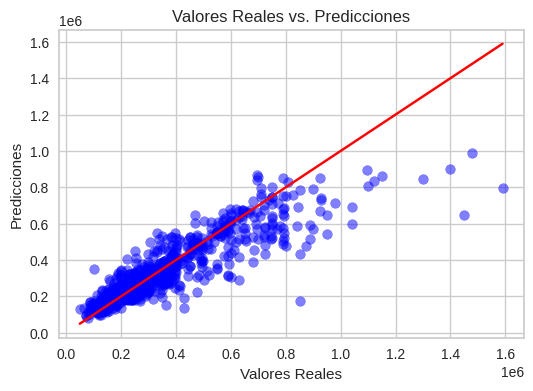

0.780772554686142

In [ ]:
mejor_modelo_knn_grid = knn_grid_search.best_estimator_
y_pred = mejor_modelo_knn_grid.predict(X_test_s)

plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')  # Puntos de predicción
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Línea de predicción perfecta
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Valores Reales vs. Predicciones')
plt.show()

r2_score(y_test, y_pred)

In [ ]:
results_df = save_results(knn_grid_search, 'Knn', X_test_s, y_test, results_df)
results_df.sort_values(by='test_score', ascending=False)

,test_score,cross_val_score
Lasso CV,0.806039,0.794793
Knn,0.780773,0.802074


En cuanto al test, hemos obtenido una R2 de 0.78, ligeramente inferior al modelo anterior, parece ser que este modelo tiende a predecir los valores más a la baja que el anterior ya que a partir de los valores reales de 0.9 todos los valores predichos incorrectamente son inferiores a los reales. Por otro lado los valores reales pequeños los sigue prediciendo de manera correcta como el anterior modelo en la mayoría de casos.

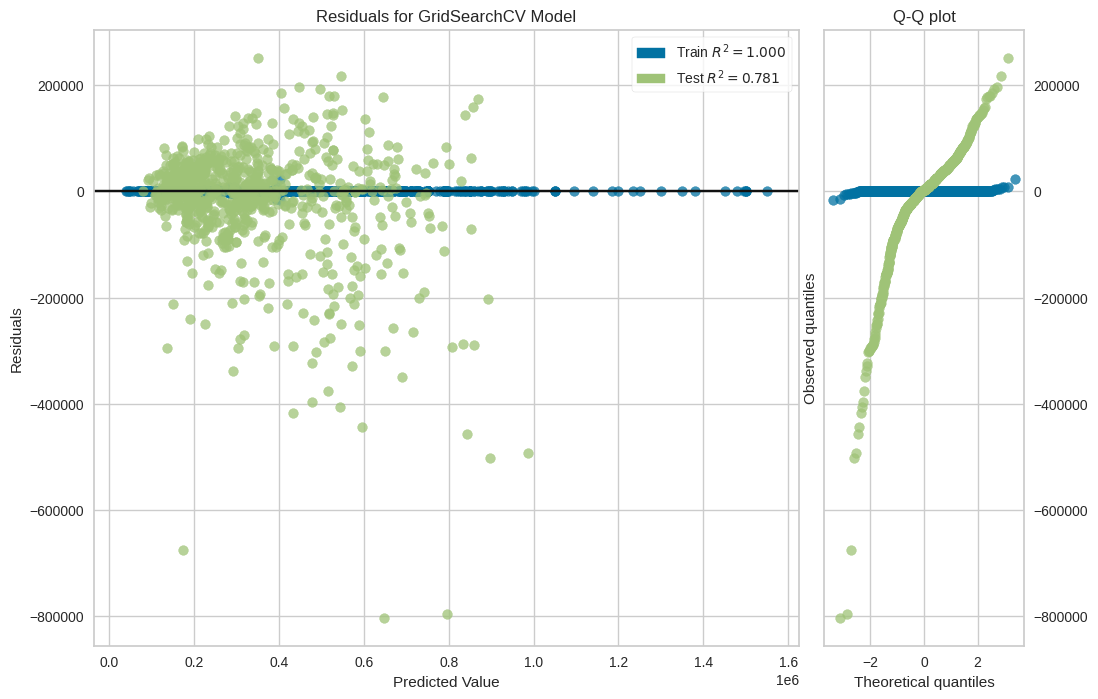

In [ ]:
plt.figure(figsize=(12,8));
viz = residuals_plot(knn_grid_search, X_train_s, y_train, X_test_s, y_test, is_fitted=True, qqplot=True, hist=False)

Podemos ver un resultado curioso, la R2 de train es de 1, esto significa que el modelo acierta en todos los datos osea que se ha memorizado al completo el conjunto de datos de entrenamiento haciendo un overfitting, esto se puede confirmar al ver que la R2 de test es peor que en el modelo anterior.

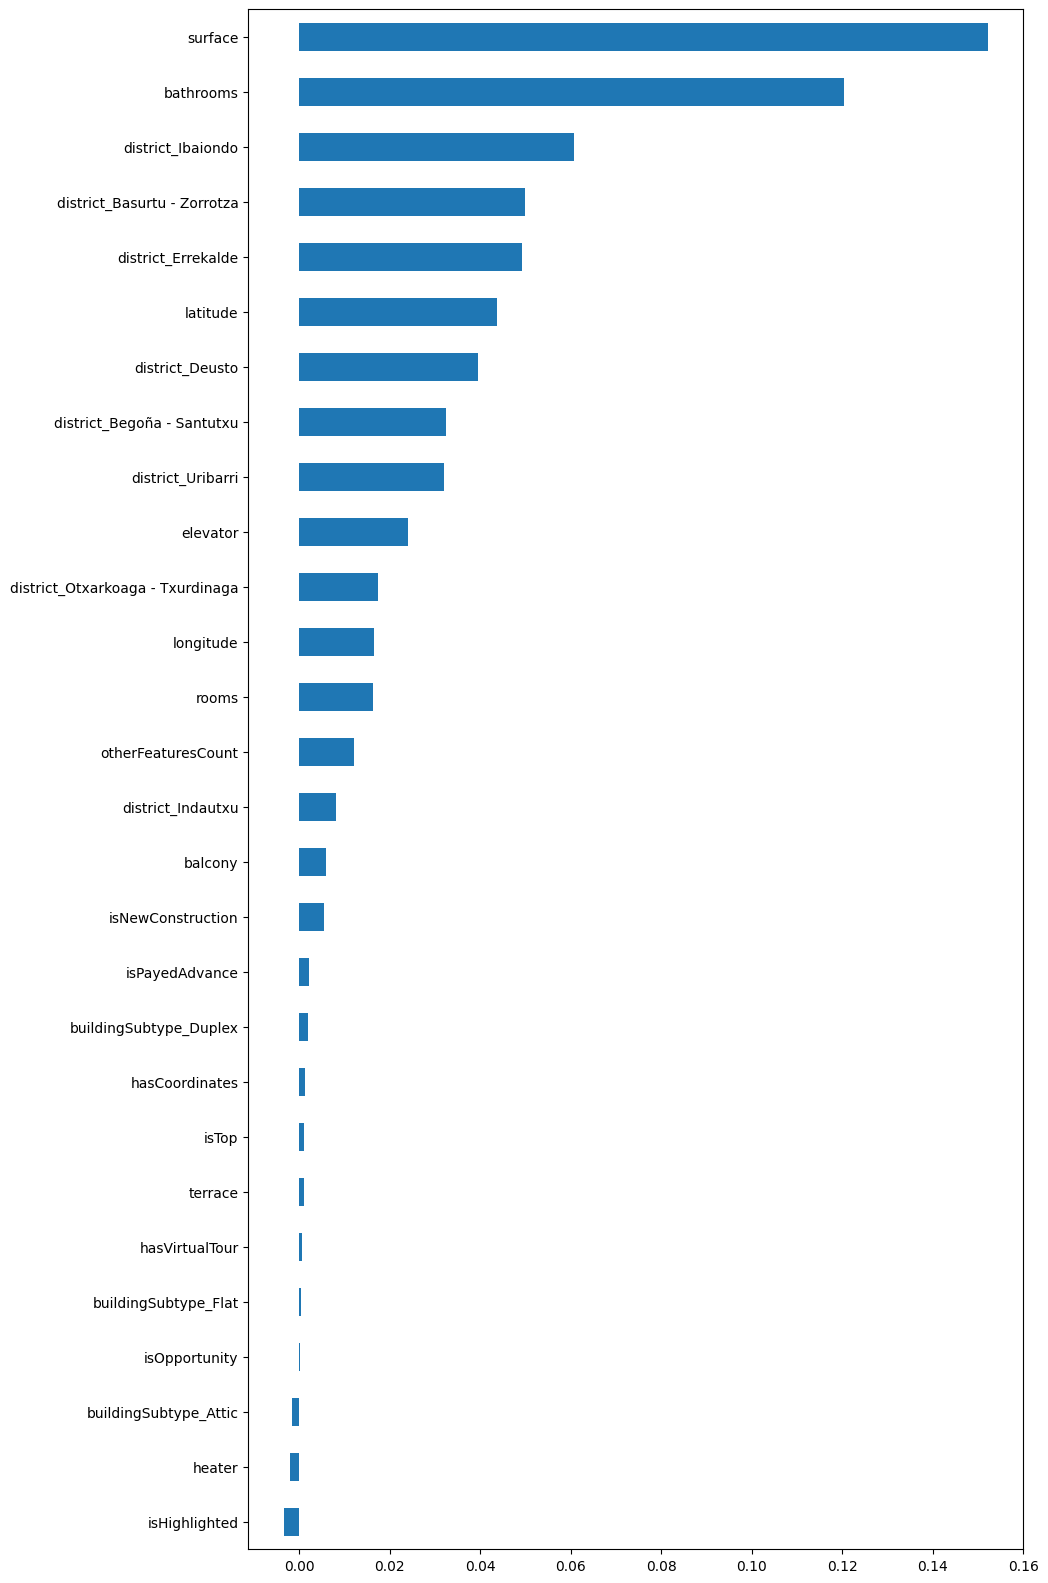

In [ ]:
c = choice(X_test_s.shape[0], size=X_test_s.shape[0], replace=False)
pi = permutation_importance(knn_grid_search, X_test_s.iloc[c,:], y_test.to_numpy()[c], n_jobs=-1, random_state=14)
var_imp_knn = pd.DataFrame({'importance': pi.importances_mean}, index=X_test_s.columns)
var_imp_knn.sort_values(by='importance').plot.barh(figsize=(10,20), legend=False);

Podemos ver como surface sigue siendo la variable con más importancia, ahora le sigue bathrooms, lo cual tiene sentido ya que normalmente una casa con más baños será más grande y valdrá más. Seguimos teniendo cerca Ibaiondo como en el anterior modelo.

### SVR Lineal

Vamos a comprobar que SVM da mejores resultados si el modelo con kernel lineal o cuadrático, y nos quedaremos con el mejor de ambos

In [ ]:
from sklearn.svm import SVR

modelo_svm_lineal = SVR(kernel='linear')

# El modelo de Máquina de Soporte Vectorial (SVM) lineal en Scikit-learn tiene varios parametros que se pueden ajustar y probar para mejorar el rendimiento del modelo:
#
# C: regularización
# epsilon: margen de tolerancia en la función de pérdida


parametros = {
    'C':10**np.linspace(-1,5,20),
    'epsilon':np.linspace(0,0.01,11)
}

In [ ]:
svm_lineal_grid_search = GridSearchCV(modelo_svm_lineal, parametros, cv=cv, n_jobs = -1) # Configuramos el uso del modelo svm lineal con nuestros posibles parametros, una validacion cruzada de 10 iteraciones
svm_lineal_grid_search.fit(X_train_s, y_train) # Entrenamos con nuestros datos

GridSearchCV(cv=10, estimator=SVR(kernel='linear'), n_jobs=-1,
             param_grid={'C': array([1.00000000e-01, 2.06913808e-01, 4.28133240e-01, 8.85866790e-01,
       1.83298071e+00, 3.79269019e+00, 7.84759970e+00, 1.62377674e+01,
       3.35981829e+01, 6.95192796e+01, 1.43844989e+02, 2.97635144e+02,
       6.15848211e+02, 1.27427499e+03, 2.63665090e+03, 5.45559478e+03,
       1.12883789e+04, 2.33572147e+04, 4.83293024e+04, 1.00000000e+05]),
                         'epsilon': array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
       0.009, 0.01 ])})

In [ ]:
show_html(pd.DataFrame(svm_lineal_grid_search.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
176,"{'C': 11288.378916846883, 'epsilon': 0.0}",0.815088,1
177,"{'C': 11288.378916846883, 'epsilon': 0.001}",0.815088,2
178,"{'C': 11288.378916846883, 'epsilon': 0.002}",0.815088,3
179,"{'C': 11288.378916846883, 'epsilon': 0.003}",0.815088,4
180,"{'C': 11288.378916846883, 'epsilon': 0.004}",0.815088,5


Una primera versión explorando los hiperparámetros de C hasta 10e3 dió unos resultados parecidos a los de knn, así que hemos ampliado el valor de C para encontrar de manera adecuada los mejores parámetros. Al final hemos obtenido que el mejor resultado es con una C con valor de 11288, haciendo que obtengamos un mean test score de 0.815.

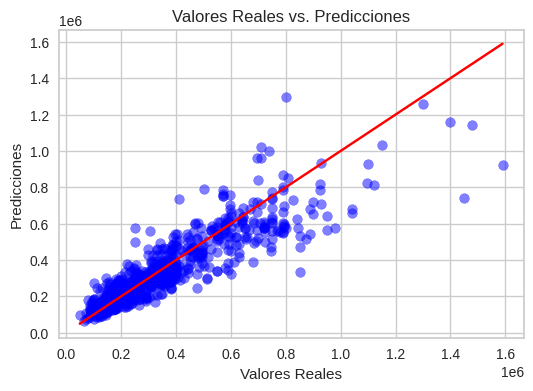

0.7969151957161729

In [ ]:
mejor_modelo_svm_lineal_grid = svm_lineal_grid_search.best_estimator_
y_pred = mejor_modelo_svm_lineal_grid.predict(X_test_s)

plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')  # Puntos de predicción
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Línea de predicción perfecta
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Valores Reales vs. Predicciones')
plt.show()

r2_score(y_test, y_pred)

In [ ]:
results_df = save_results(svm_lineal_grid_search, 'SVM Lineal', X_test_s, y_test, y_pred, results_df)
results_df.sort_values(by='test_score', ascending=False)

,test_score,cross_val_score
Lasso CV,0.806039,0.794793
SVM Lineal,0.796915,0.815088
Knn,0.780773,0.802074


Hemos obtenido una R2 parecida a la de knn, ligeramente mejor de 0.797 aproximadamente, vamos a compararlo con el modelo poly para ver cual es mejor y con que modelo nos quedamos.

Cabe destacar que estos modelos tardan mucho más debido a que estamos explorando un espacio de hiperparámetros mucho mayor a los anteriores casos.

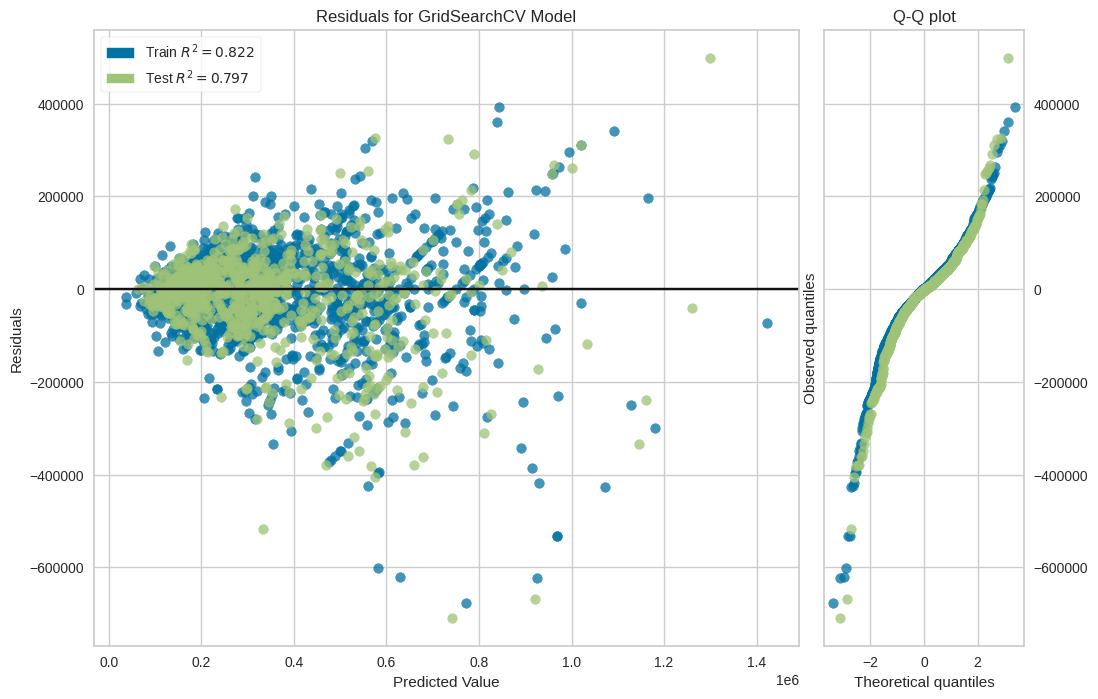

In [ ]:
plt.figure(figsize=(12,8));
viz = residuals_plot(svm_lineal_grid_search, X_train_s, y_train, X_test_s, y_test, is_fitted=True, qqplot=True, hist=False)

Los residuos de este modelo se parecen a los del Lasso, además hemos obtenido valores similares, como veremos a continuación la importancia que le damos a las variables también es parecida, así que podemos suponer que son modelos que predicen de manera similar.

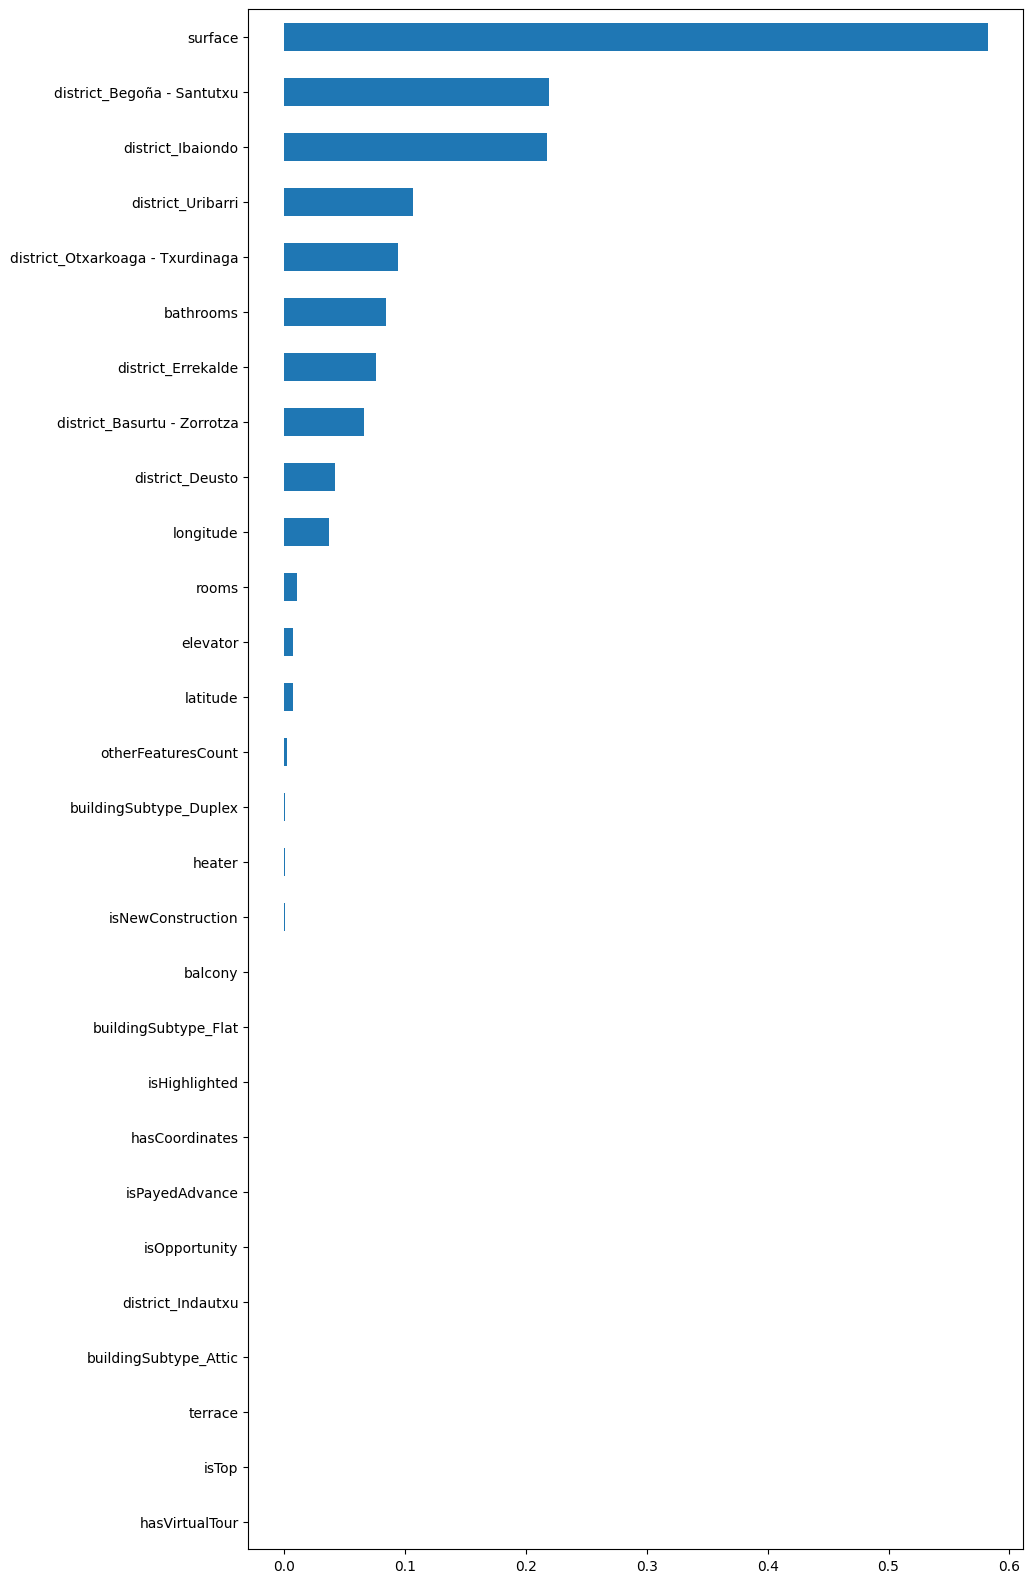

In [ ]:
c = choice(X_test_s.shape[0], size=X_test_s.shape[0], replace=False)
pi = permutation_importance(svm_lineal_grid_search, X_test_s.iloc[c,:], y_test.to_numpy()[c], n_jobs=-1, random_state=14)
var_imp_svm_lineal = pd.DataFrame({'importance': pi.importances_mean}, index=X_test_s.columns)
var_imp_svm_lineal.sort_values(by='importance').plot.barh(figsize=(10,20), legend=False);

Las variables más importantes con este modelo son muy parecidas a las del modelo lassocv, lideradas por surface de nuevo y se han intercambiado de lugar santutxu con ibaiondo. Parece que estos pesos son algo mejores que los escogido por knn.

### SVR Cuadrática

In [ ]:

modelo_svm_cuadratico = SVR(kernel='poly', max_iter=25000)

# El modelo de Máquina de Soporte Vectorial (SVM) cuadrática en Scikit-learn tiene varios parametros que se pueden ajustar y probar para mejorar el rendimiento del modelo:
#
# C: regularización
# epsilon: margen de tolerancia en la función de pérdida
# coef0 : Término independiente en el kernel

parametros = {
    'C':10**np.linspace(-1,4,20),
    'degree':[2,3],
    'epsilon': [0, 0.2, 0.5, 1],
    'coef0': [1, 10, 20]
}

In [ ]:
svm_cuadratico_grid_search = GridSearchCV(modelo_svm_cuadratico, parametros, cv=cv, n_jobs = -1) # Configuramos el uso del modelo svm lineal con nuestros posibles parametros, una validacion cruzada de 10 iteraciones
svm_cuadratico_grid_search.fit(X_train_s, y_train) # Entrenamos con nuestros datos

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=25000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


GridSearchCV(cv=10, estimator=SVR(kernel='poly', max_iter=25000), n_jobs=-1,
             param_grid={'C': array([1.00000000e-01, 1.83298071e-01, 3.35981829e-01, 6.15848211e-01,
       1.12883789e+00, 2.06913808e+00, 3.79269019e+00, 6.95192796e+00,
       1.27427499e+01, 2.33572147e+01, 4.28133240e+01, 7.84759970e+01,
       1.43844989e+02, 2.63665090e+02, 4.83293024e+02, 8.85866790e+02,
       1.62377674e+03, 2.97635144e+03, 5.45559478e+03, 1.00000000e+04]),
                         'coef0': [1, 10, 20], 'degree': [2, 3],
                         'epsilon': [0, 0.2, 0.5, 1]})

In [ ]:
show_html(pd.DataFrame(svm_cuadratico_grid_search.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
421,"{'C': 2976.351441631319, 'coef0': 10, 'degree': 3, 'epsilon': 0.2}",0.839068,1
470,"{'C': 10000.0, 'coef0': 10, 'degree': 3, 'epsilon': 0.5}",0.839018,2
445,"{'C': 5455.594781168515, 'coef0': 10, 'degree': 3, 'epsilon': 0.2}",0.839016,3
422,"{'C': 2976.351441631319, 'coef0': 10, 'degree': 3, 'epsilon': 0.5}",0.838998,4
420,"{'C': 2976.351441631319, 'coef0': 10, 'degree': 3, 'epsilon': 0}",0.838986,5


Vemos que el mejor modelo es con una C de 2976 y un coef0 de 10. El valor que obtenemos de mean_test_score es de 0.839, mejorando el del modelo anterior lineal y todos los demás modelos anteriores.

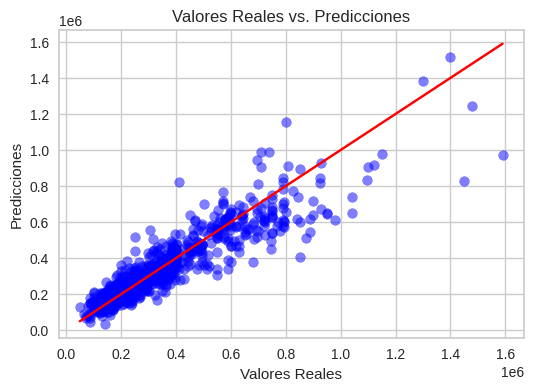

0.8367072454874903

In [ ]:
mejor_modelo_svm_cuadratico_grid = svm_cuadratico_grid_search.best_estimator_
y_pred = mejor_modelo_svm_cuadratico_grid.predict(X_test_s)

plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')  # Puntos de predicción
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Línea de predicción perfecta
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Valores Reales vs. Predicciones')
plt.show()

r2_score(y_test, y_pred)

In [ ]:
results_df = save_results(svm_cuadratico_grid_search, 'SVM Cuadrático', X_test_s, y_test, results_df)
results_df.sort_values(by='test_score', ascending=False)

,test_score,cross_val_score
SVM Cuadrático,0.836707,0.839068
Lasso CV,0.806039,0.794793
SVM Lineal,0.796915,0.815088
Knn,0.780773,0.802074


Hemos obtenido una R2 de 0.837, mejor que el método lineal así que de SVM usaremos la cuadrática.

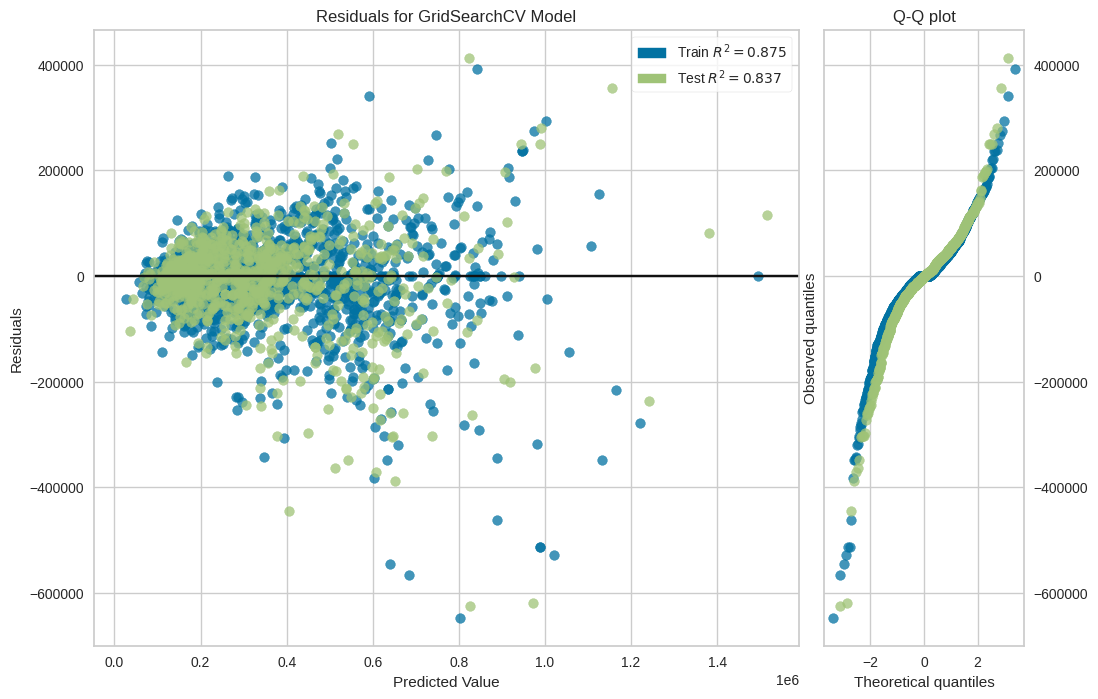

In [ ]:
plt.figure(figsize=(12,8));
viz = residuals_plot(svm_cuadratico_grid_search, X_train_s, y_train, X_test_s, y_test, is_fitted=True, qqplot=True, hist=False)

Podemos ver que este modelo tiene un plot de residuos algo mejor que los anteriores, se puede ver como hay más puntos concentrados al rededor del 0 en los primeros valores, formando una forma algo más de nube en comparación a los modelos anteriores donde era algo más triangular, expandiéndose a los lados a medida que aumentaban los valores predichos.

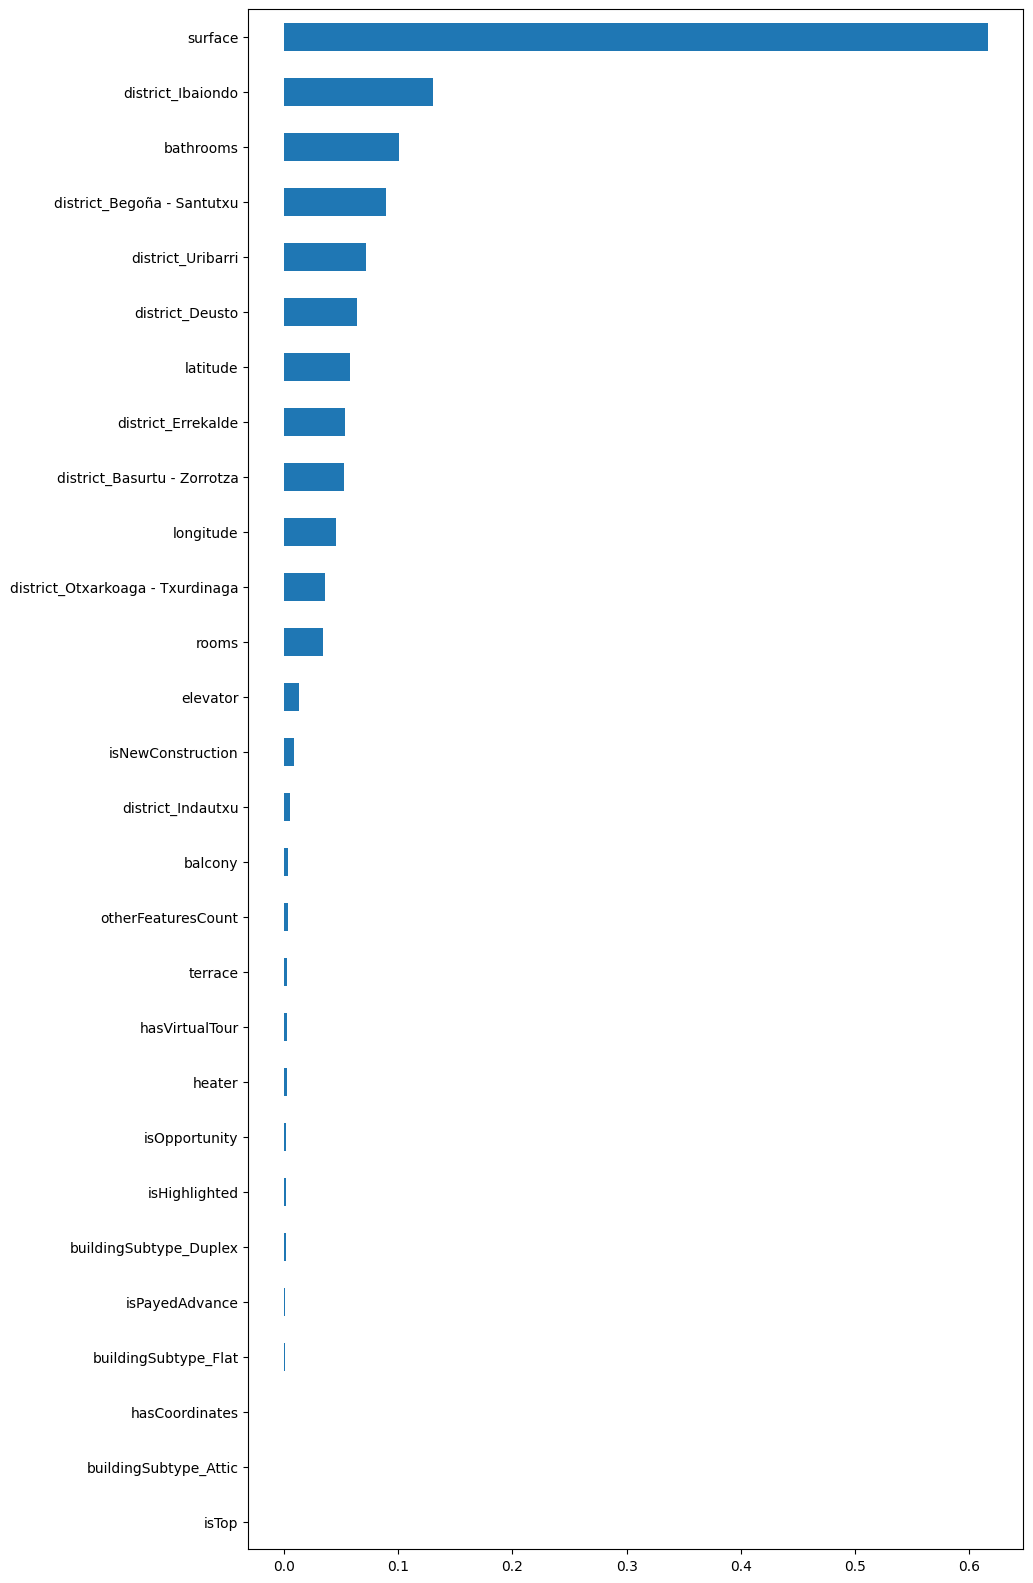

In [ ]:
c = choice(X_test_s.shape[0], size=X_test_s.shape[0], replace=False)
pi = permutation_importance(svm_cuadratico_grid_search, X_test_s.iloc[c,:], y_test.to_numpy()[c], n_jobs=-1, random_state=14)
var_imp_svm_cuadratico = pd.DataFrame({'importance': pi.importances_mean}, index=X_test_s.columns)
var_imp_svm_cuadratico.sort_values(by='importance').plot.barh(figsize=(10,20), legend=False);

Este modelo parece dar aun más importancia a surface en comparación al resto, haciendo que los resultados sean mejores.

## Métodos no lineales

In [ ]:
modelo_svr_rbf = SVR(kernel='rbf', max_iter=30000) # Creamos un modelo (Support Vector Regression) ya que nuestro problema es de regresión con kernel RBF

# El modelo SVR en Scikit-learn tiene varios parametros que se pueden ajustar y probar para mejorar el rendimiento del modelo :
#
# kernel: este especifica el tipo de kernel que utiliza el algoritmo (ya lo hemos asignado previamente) pero puede ser 'linear', 'poly', 'rbf', 'sigmoid y otros
# C: controla el trade-off entre lograr un margen alto y clasificar los puntos de entrenamiento correctamente (un valor más alto significa menos regularizacion) y puede llevar al sobreajuste especialmente si el conjunto de datos tiene ruido
# epsilon: margen de error hasta el que se penaliza la diferencia entre la predicción real y la del modelo
# gamma: es el coeficiente para los kernels poly, rbf y sigmoid
# degree: grado del polinomio (solo es para el kernel poly asi que no lo usaremos)
# coef0: otro parametro para oplimizar solamente para el kernel poly y sigmoid (no lo usaremos)

parametros = {
    'C':10**np.linspace(-1,7,20),
    'gamma': ['auto', 'scale'],
    'epsilon': [0, 0.01, 0.1, 0.2, 0.5, 1],
}

In [ ]:
svr_rbf_grid_search = GridSearchCV(modelo_svr_rbf, parametros, cv=cv, n_jobs=-1)
svr_rbf_grid_search.fit(X_train_s, y_train)

GridSearchCV(cv=10, estimator=SVR(max_iter=30000), n_jobs=-1,
             param_grid={'C': array([1.00000000e-01, 2.63665090e-01, 6.95192796e-01, 1.83298071e+00,
       4.83293024e+00, 1.27427499e+01, 3.35981829e+01, 8.85866790e+01,
       2.33572147e+02, 6.15848211e+02, 1.62377674e+03, 4.28133240e+03,
       1.12883789e+04, 2.97635144e+04, 7.84759970e+04, 2.06913808e+05,
       5.45559478e+05, 1.43844989e+06, 3.79269019e+06, 1.00000000e+07]),
                         'epsilon': [0, 0.01, 0.1, 0.2, 0.5, 1],
                         'gamma': ['auto', 'scale']})

In [ ]:
show_html(pd.DataFrame(svr_rbf_grid_search.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
202,"{'C': 545559.4781168514, 'epsilon': 1, 'gamma': 'auto'}",0.832078,1
200,"{'C': 545559.4781168514, 'epsilon': 0.5, 'gamma': 'auto'}",0.832078,2
198,"{'C': 545559.4781168514, 'epsilon': 0.2, 'gamma': 'auto'}",0.832077,3
196,"{'C': 545559.4781168514, 'epsilon': 0.1, 'gamma': 'auto'}",0.832077,4
194,"{'C': 545559.4781168514, 'epsilon': 0.01, 'gamma': 'auto'}",0.832077,5


En una primera ejecución obtuvimos resultados muy malos con una C máxima de 10e3, entonces ampliamos la búsqueda hasta 10e4. El resultado mejoró sustancialmente pero aun así todos los mejores aproximadores usaban 10e4 así que la ampliamos hasta 10e5 y luego hasta 10e7 para asegurarnos. Con esto obtuvimos que los mejores hiperparámetros eran de una C con valor 545559, epsilon de 1 y gamma en auto, con un resultado de mean test score de 0.832.

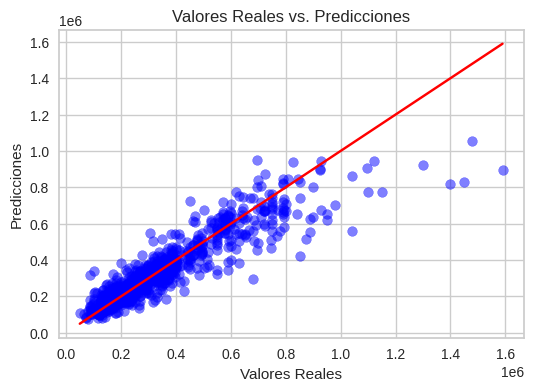

0.8334580503385172

In [ ]:
mejor_modelo_svr_rbf_grid = svr_rbf_grid_search.best_estimator_
y_pred = mejor_modelo_svr_rbf_grid.predict(X_test_s)

plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')  # Puntos de predicción
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Línea de predicción perfecta
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Valores Reales vs. Predicciones')
plt.show()

r2_score(y_test, y_pred)

In [ ]:
results_df = save_results(svr_rbf_grid_search, 'SVM RBF', X_test_s, y_test, results_df)
results_df.sort_values(by='test_score', ascending=False)

,test_score,cross_val_score
SVM Cuadrático,0.836707,0.839068
SVM RBF,0.833458,0.832078
Lasso CV,0.806039,0.794793
SVM Lineal,0.796915,0.815088
Knn,0.780773,0.802074


Hemos obtenido una R2 de 0.833, muy parecida a la del modelo lineal con kernel polinómico.

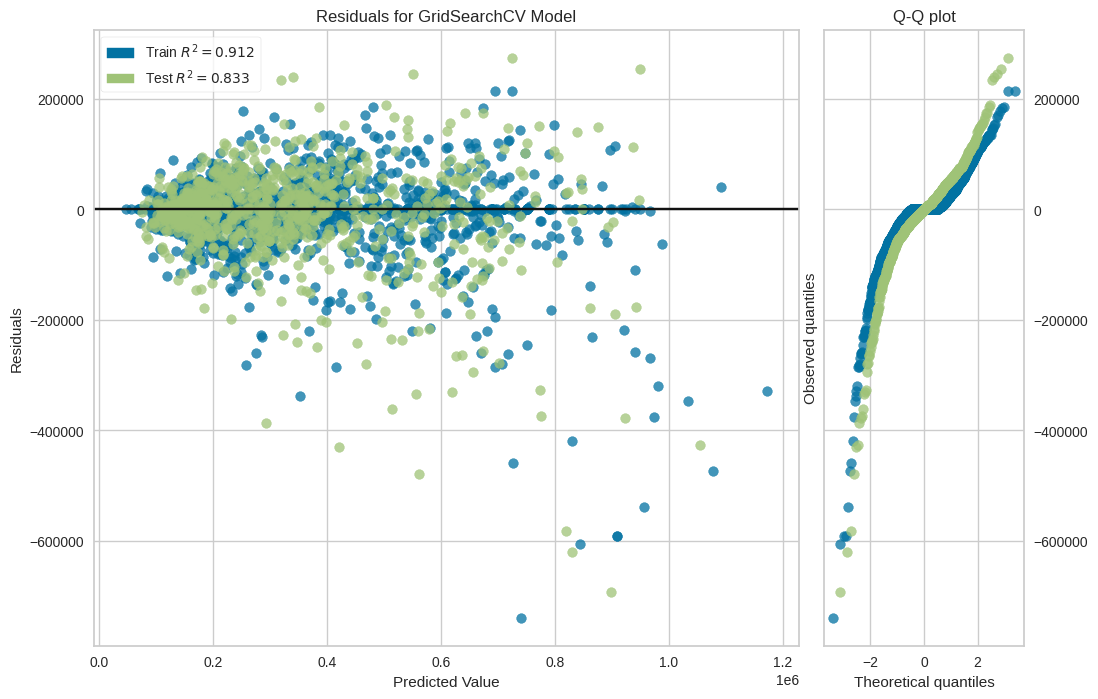

In [ ]:
plt.figure(figsize=(12,8));
viz = residuals_plot(svr_rbf_grid_search, X_train_s, y_train, X_test_s, y_test, is_fitted=True, qqplot=True, hist=False)

Podemos ver resultados aún mejores que en los modelos anteriores con los datos de train, con una forma similar de residuos pero más agrupados en el centro y menos valores extremos con predicciones muy erroneas. En cuanto a los datos de test los resultados son muy ligeramente peores, apenas perceptible en el plot.

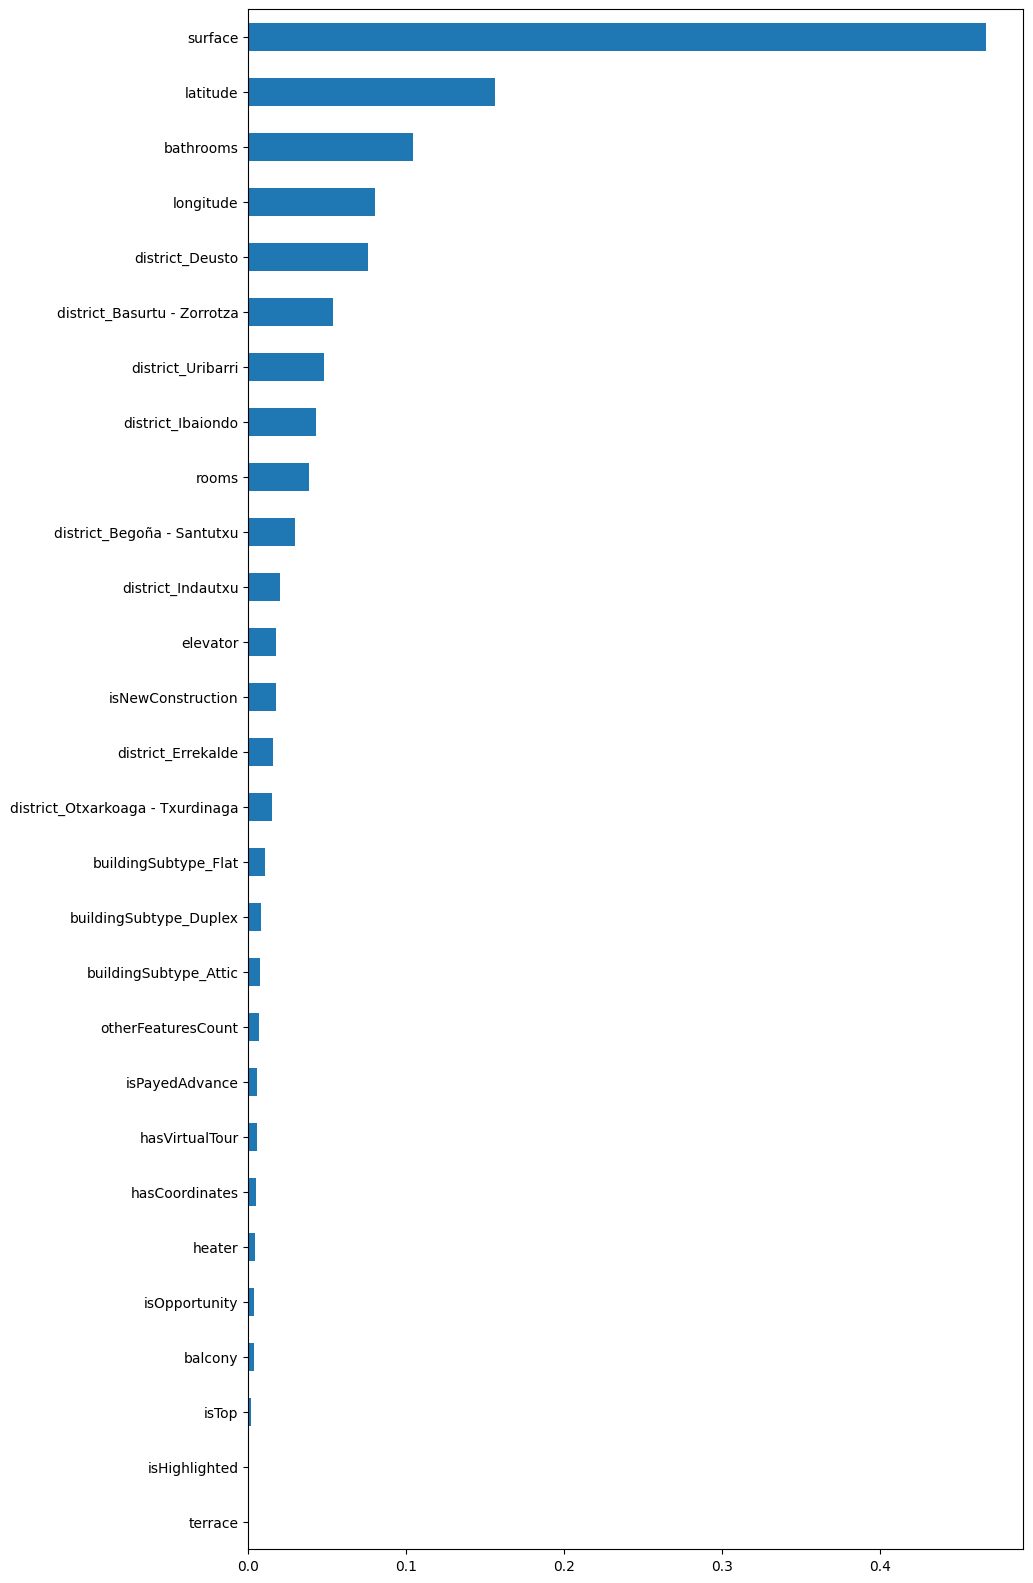

In [ ]:
c = choice(X_test_s.shape[0], size=X_test_s.shape[0], replace=False)
pi = permutation_importance(svr_rbf_grid_search, X_test_s.iloc[c,:], y_test.to_numpy()[c], n_jobs=-1, random_state=14)
var_imp_svm_rbf = pd.DataFrame({'importance': pi.importances_mean}, index=X_test_s.columns)
var_imp_svm_rbf.sort_values(by='importance').plot.barh(figsize=(10,20), legend=False);

Se le sigue dando mucha importancia a surface, en este caso la variable latitud gana importancia poniéndose en 2o puesto, le siguen bathrooms y longitude.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

modelo_rf = RandomForestRegressor()

# El modelo RandomForestRegressor en Scikit-learn tiene varios parametros que se pueden ajustar y probar para mejorar el rendimiento del modelo :
#
# n_stimators: número de árboles en el bosque (mayor número aumenta el rendimiento y hace que las predicciones sean más estables pero augmenta el tiempo de cómputo y el uso de memoria)
# max_depth: produndidad máxima de cada árbol (valores altos permiten que el modelo capture más información pero pueden llevar a sobreajustes, valores bajos permiten prevenir sobreajuste pero pueden ser demasiado simples)
# min_samples_split: número minimo de muestras necesarias para dividir un nodo interno (valores altos evitan la creación de nodos que modelan el ruido por lo que pueden prevenir el sobreajuste)
# min_samples_leaf: número minimo de muestras requeridas para ser una hoja de un nodo (números grandes aumentan la generalización del modelo)
# max_features: número máximo de características consideradas para dividir un nodo (puede mejorar la diversidad de los árboles en el modelo pudiendo beneficiar el rendimiento), las opciones tipicas con 'auto', 'sqrt', 'log2'
# bootstrap: método de muestreo para la construcción de los arboles ("True" muestreo con reemplazo, "False": utiliza todo el conjunto de datos para construir cada árbol)
# random_state: controla la aleatoriedad del proceso (útil para reproducibilidad de resultados)

parametros = {
    'n_estimators': [5, 10, 25, 50, 75, 100, 200],
    'max_depth': [1, 2, 5, 8, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10],
}

In [ ]:
rf_grid_search = GridSearchCV(modelo_rf, parametros, cv=cv, n_jobs = -1)
#rf_bayes_search = BayesSearchCV(modelo_rf, parametros, scoring='neg_mean_squared_error', n_jobs=-1)
rf_grid_search.fit(X_train_s, y_train)
#rf_bayes_search.fit(casas_train_estandarizadas, solucion_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 5, 8, 10, 15, None],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [5, 10, 25, 50, 75, 100, 200]})

In [ ]:
show_html(pd.DataFrame(rf_grid_search.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
529,"{'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 75}",0.872457,1
535,"{'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}",0.871943,2
445,"{'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 75}",0.871356,3
426,"{'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}",0.871256,4
536,"{'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 75}",0.871175,5


Vemos que el mejor modelo es sin profundidad máxima, usando 2 de min_samples_leaf y 75 árboles. Con un resultado de test de 0.872 que es muy alto, este modelo es el mejor con diferencia hasta ahora.

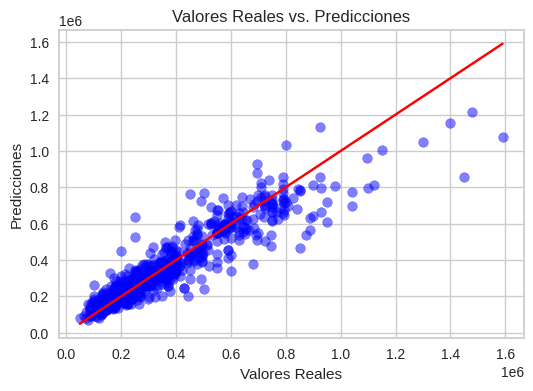

0.8667279816531945

In [ ]:
from sklearn.metrics import r2_score
mejor_modelo_rf_grid = rf_grid_search.best_estimator_
y_pred = mejor_modelo_rf_grid.predict(X_test_s)

plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')  # Puntos de predicción
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Línea de predicción perfecta
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Valores Reales vs. Predicciones')
plt.show()

r2_score(y_test, y_pred)

In [ ]:
results_df = save_results(rf_grid_search, 'Random Forest Regressor', X_test_s, y_test, results_df)
results_df.sort_values(by='test_score', ascending=False)

,test_score,cross_val_score
Random Forest Regressor,0.866728,0.872457
SVM Cuadrático,0.836707,0.839068
SVM RBF,0.833458,0.832078
Lasso CV,0.806039,0.794793
SVM Lineal,0.796915,0.815088
Knn,0.780773,0.802074


Vemos que el valor de R2 es de 0.867, siendo muy alto. Esto nos indica que este modelo es muy bueno predeciendo nuevos datos y confirma nuestra sospecha de que es el mejor modelo hasta ahora.

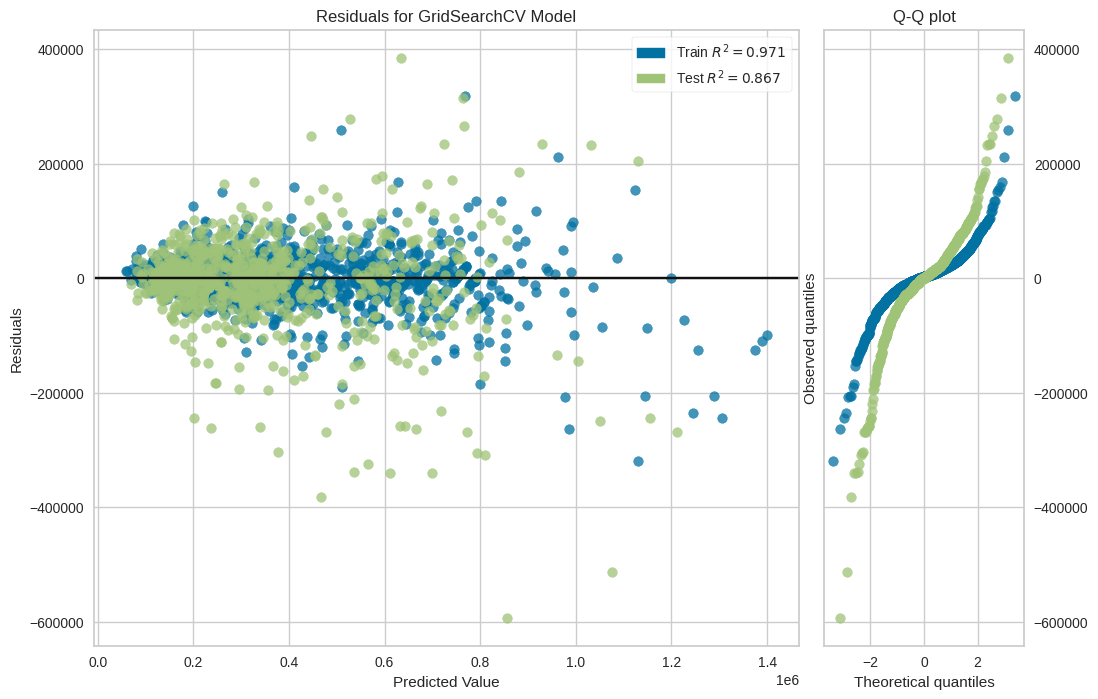

In [ ]:
plt.figure(figsize=(12,8));
viz = residuals_plot(rf_grid_search, X_train_s, y_train, X_test_s, y_test, is_fitted=True, qqplot=True, hist=False)

El plot de residuos es muy bueno, los resultados con los datos de train están muy cerca del 0 y los de test también a excepción de unos pocos algo alejados.

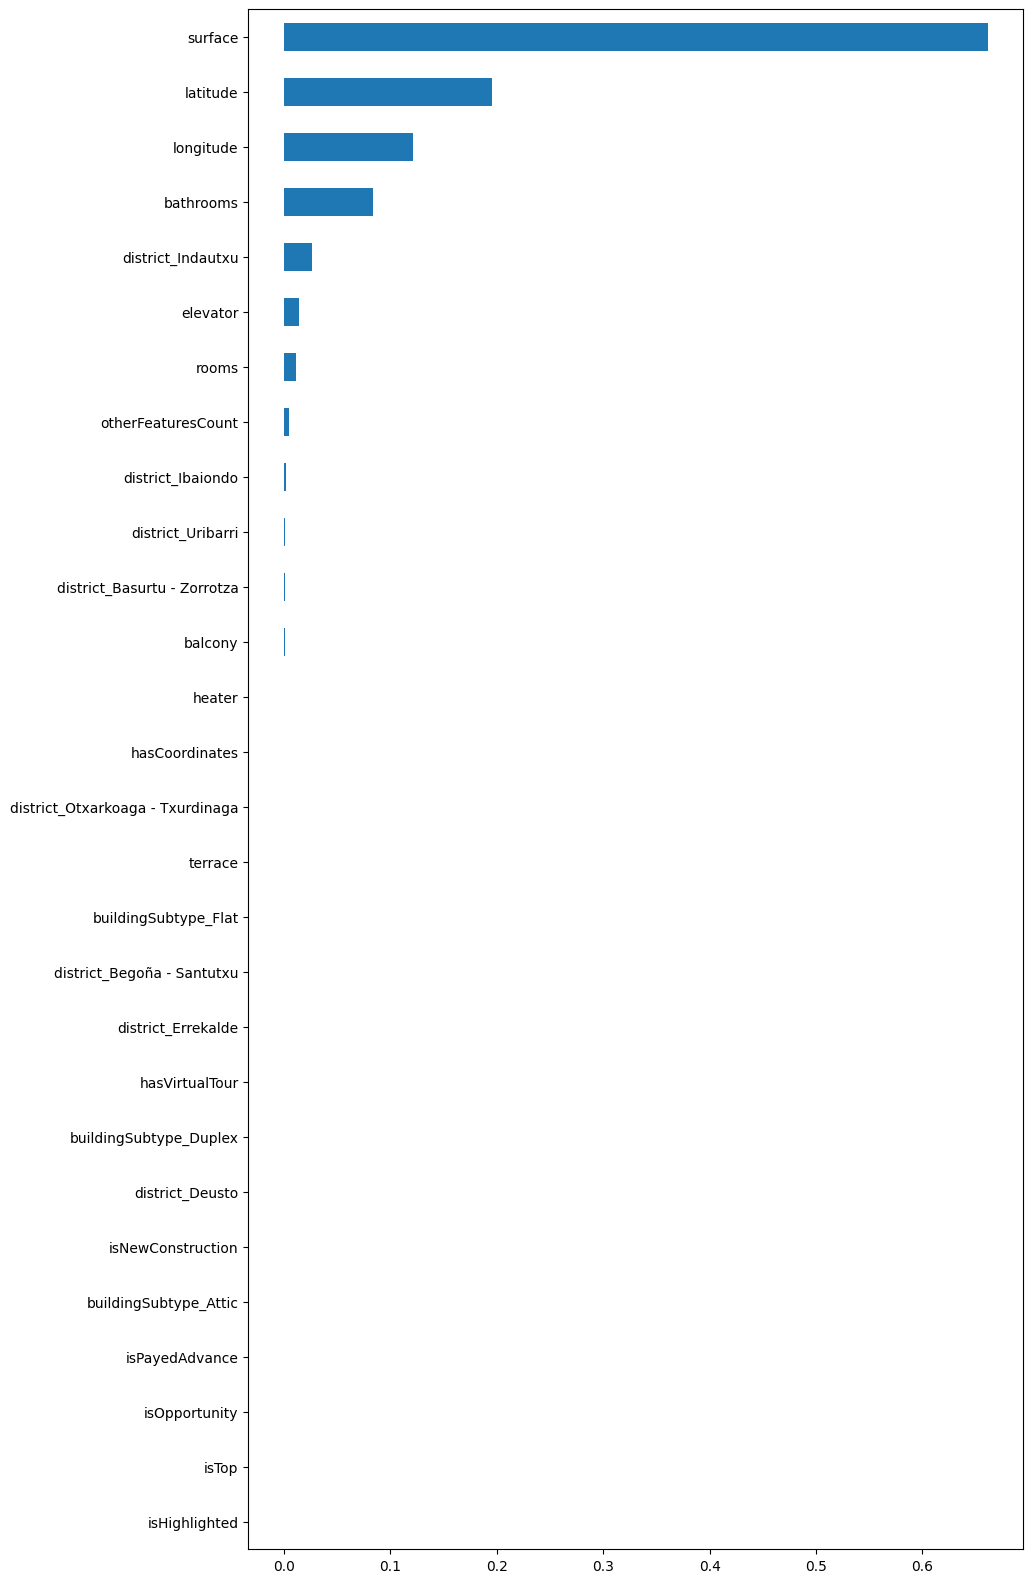

In [ ]:
c = choice(X_test_s.shape[0], size=X_test_s.shape[0], replace=False)
pi = permutation_importance(rf_grid_search, X_test_s.iloc[c,:], y_test.to_numpy()[c], n_jobs=-1, random_state=14)
var_imp_rf = pd.DataFrame({'importance': pi.importances_mean}, index=X_test_s.columns)
var_imp_rf.sort_values(by='importance').plot.barh(figsize=(10,20), legend=False);

En este modelo surface sigue siendo la variable con más importancia, latitude sigue en el 2o puesto pero ahora con algo más de importancia, longitude gana importancia y supera a bathrooms.

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

modelo_gb = GradientBoostingRegressor(n_iter_no_change=5)

# El modelo GradientBoostingRegressor en Scikit-learn tiene varios parametros que se pueden ajustar y probar para mejorar el rendimiento del modelo :
#
# n_stimators: número de árboles en el bosque (mayor número aumenta el rendimiento y hace que las predicciones sean más estables pero augmenta el tiempo de cómputo y el uso de memoria)
# learning_rate: tasa a la que el modelo se adapta a los datos en cada iteración (mayor numero puede mejorar el rendimiento pero tambien puede conducir al sobreajuste)
# max_depth: produndidad máxima de cada árbol (valores altos permiten que el modelo capture más información pero pueden llevar a sobreajustes, valores bajos permiten prevenir sobreajuste pero pueden ser demasiado simples)
# min_samples_split: número minimo de muestras necesarias para dividir un nodo interno (valores altos evitan la creación de nodos que modelan el ruido por lo que pueden prevenir el sobreajuste)
# min_samples_leaf: número minimo de muestras requeridas para ser una hoja de un nodo (números grandes aumentan la generalización del modelo)
# max_features: número máximo de características consideradas para dividir un nodo (puede mejorar la diversidad de los árboles en el modelo pudiendo beneficiar el rendimiento), las opciones tipicas con 'auto', 'sqrt', 'log2'
# subsample: fracción de muestras a utilizar para ajustar los árboles individuales
# random_state: controla la aleatoriedad del proceso (útil para reproducibilidad de resultados)
# loss: función de pérdida a optimizar
# max_leaf_nodes: número máximo de nodos terminales en los árboles (mayor numero permite árboles más complejos)
# alpha: percentil en función de la pérdida de Huber y el criterio de cuantil (específicamente relevante si se está utilizando una función de pérdida que sea sensible a outliers)

parametros = {
        'n_estimators':[10, 50, 100, 200, 300, 500],
        'learning_rate':[.001, 0.01, .1, 1, 5, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 3, 4, 5, 10],
        'max_depth':[1, 5, 10, 20],
        'subsample':[.25, .5,.75,1],
        'loss':['squared_error', 'absolute_error']}

In [ ]:
gb_bayes_search = BayesSearchCV(modelo_gb, parametros, n_iter=40, refit=True, cv=cv, n_jobs=-1)
gb_bayes_search.fit(X_train_s, y_train)

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist

BayesSearchCV(cv=10, estimator=GradientBoostingRegressor(n_iter_no_change=5),
              n_iter=40, n_jobs=-1,
              search_spaces={'learning_rate': [0.001, 0.01, 0.1, 1, 5, 10],
                             'loss': ['squared_error', 'absolute_error'],
                             'max_depth': [1, 5, 10, 20],
                             'min_samples_leaf': [1, 2, 3, 4, 5, 10],
                             'min_samples_split': [2, 5, 10],
                             'n_estimators': [10, 50, 100, 200, 300, 500],
                             'subsample': [0.25, 0.5, 0.75, 1]})

In [ ]:
show_html(pd.DataFrame(gb_bayes_search.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
1,"{'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 20, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 200, 'subsample': 0.75}",0.878587,1
12,"{'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 100, 'subsample': 0.75}",0.877985,2
5,"{'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 100, 'subsample': 0.75}",0.874861,3
38,"{'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 100, 'subsample': 0.75}",0.873768,4
31,"{'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 200, 'subsample': 0.75}",0.871056,5


Podemos ver como los mejores hiperparámetros son 200 etapas de refuerzo (boosting), el algoritmo de gradient boosting es bastante robusto a hacer overfitting así que suele ser bueno poner valores altos en n_estimators. Un learning_rate de 0.1, una profundidad máxima de 20, un subsample de 0.75 y usando de función de pérdida el mse. Obtenemos un mean_test_score de 0.879, bastante alto teniendo en cuenta que hemos usado bayes search y no grid search que es exhaustivo. Hemos usado bayes search ya que con gridsearch la ejecución tardaba muchísimas horas.

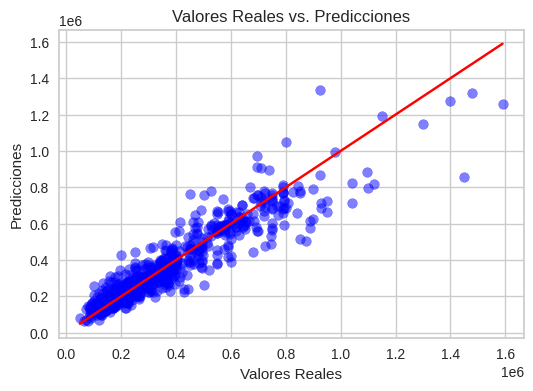

0.874462177184722

In [ ]:
from sklearn.metrics import r2_score
mejor_modelo_gb_bayes = gb_bayes_search.best_estimator_
y_pred = mejor_modelo_gb_bayes.predict(X_test_s)

plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')  # Puntos de predicción
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Línea de predicción perfecta
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Valores Reales vs. Predicciones')
plt.show()

r2_score(y_test, y_pred)

In [ ]:
results_df = save_results(gb_bayes_search, 'Gradient Boosting Regressor', X_test_s, y_test, results_df)
results_df.sort_values(by='test_score', ascending=False)

,test_score,cross_val_score
Gradient Boosting Regressor,0.874462,0.878587
Random Forest Regressor,0.866728,0.872457
SVM Cuadrático,0.836707,0.839068
SVM RBF,0.833458,0.832078
Lasso CV,0.806039,0.794793
SVM Lineal,0.796915,0.815088
Knn,0.780773,0.802074


Hemos obtenido una R2 de 0.874, el valor más alto hasta ahora, superando el del random forest Regressor. Podemos suponer que estamos ante el mejor modelo a falta de revisar el valor de la R2.

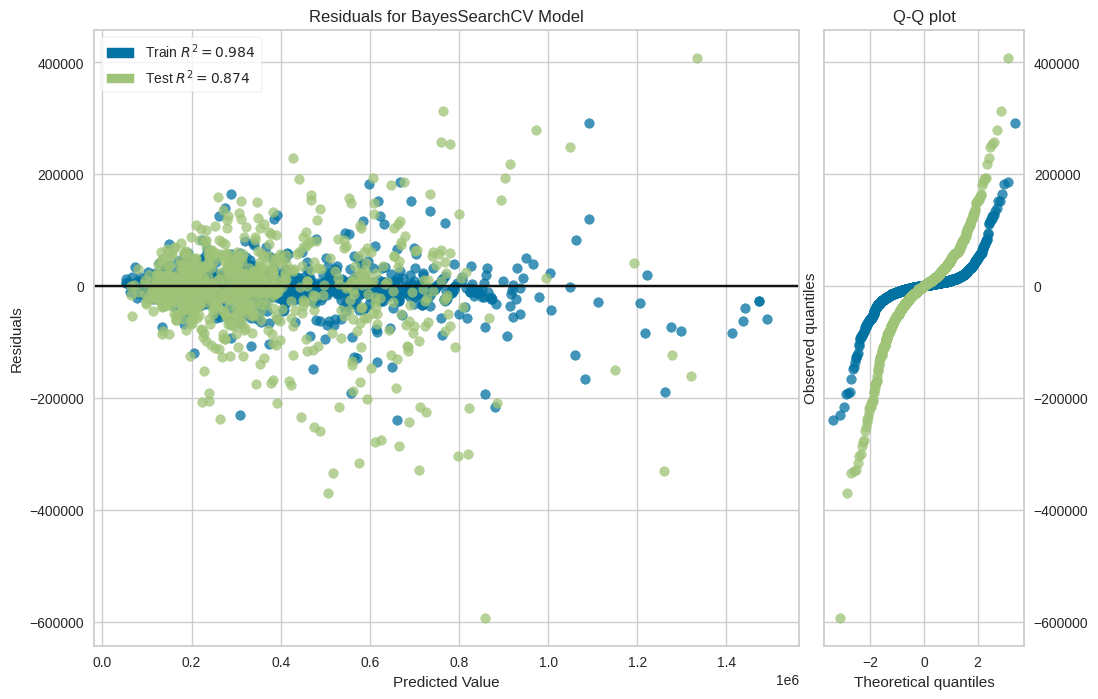

In [ ]:
plt.figure(figsize=(12,8));
viz = residuals_plot(gb_bayes_search, X_train_s, y_train, X_test_s, y_test, is_fitted=True, qqplot=True, hist=False)

El plot de residuos es algo diferente al anterior, siendo ligeramente mejor el valor de R2. Parece que con los valores más altos tiene varios valores predichos bastante más bajos de lo que debería. De todas maneras obtenemos unos resultados muy buenos, siendo este el mejor modelo de todos los vistos en la práctica.

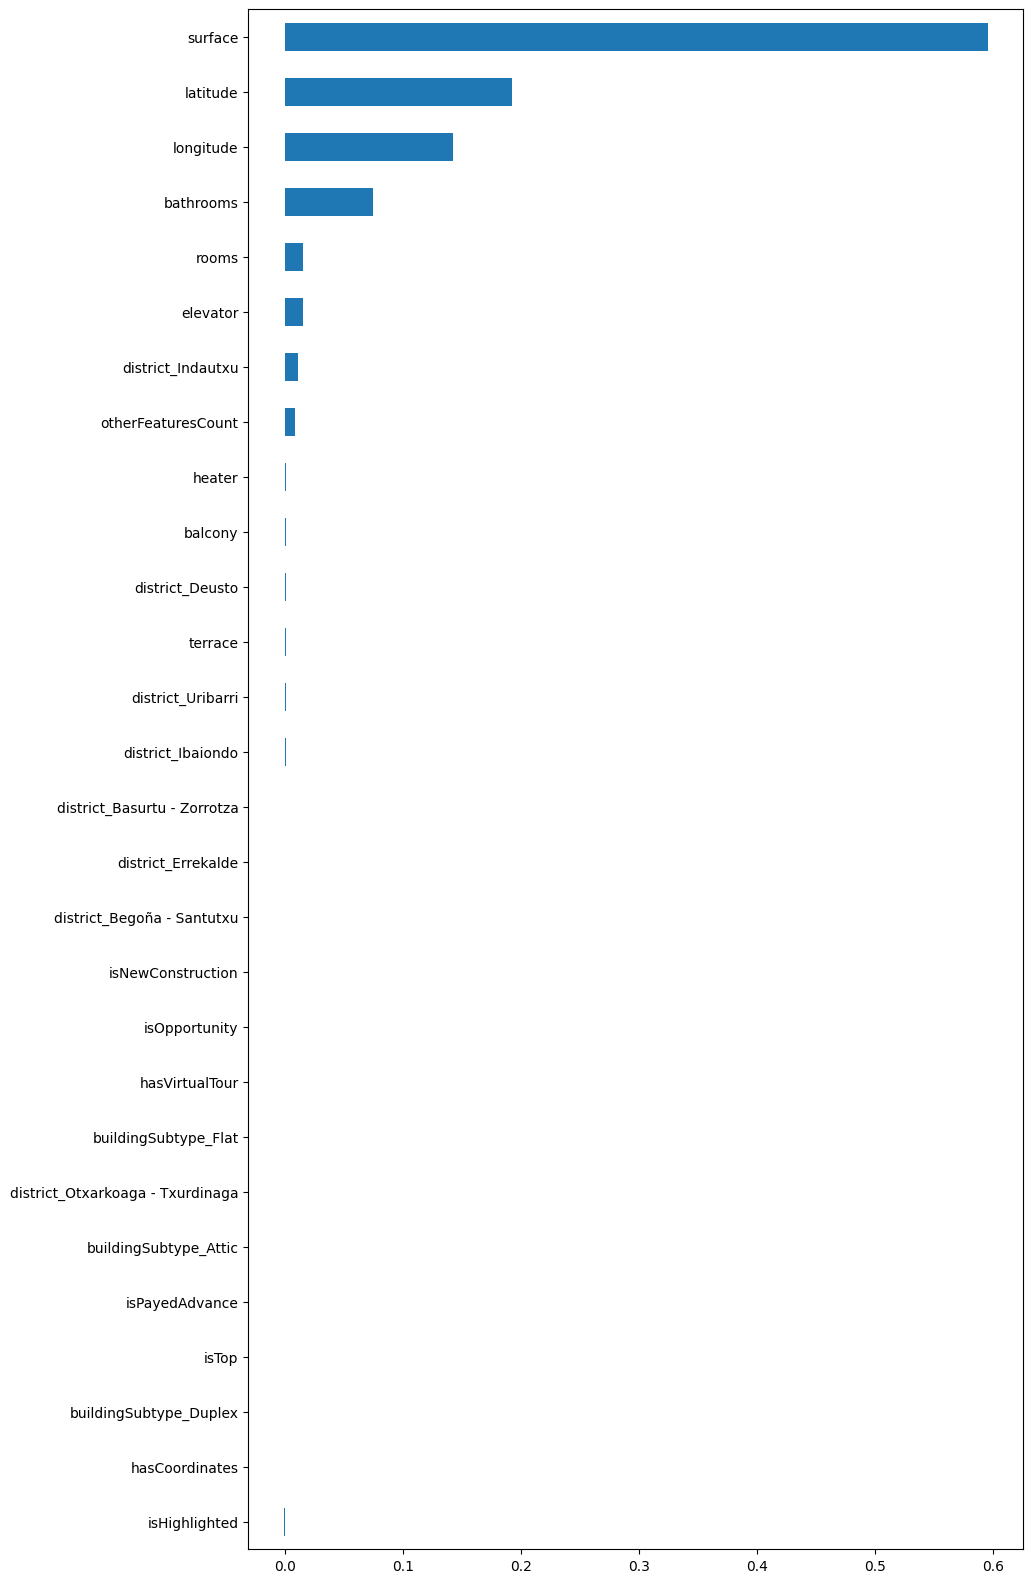

In [ ]:
c = choice(X_test_s.shape[0], size=X_test_s.shape[0], replace=False)
pi = permutation_importance(gb_bayes_search, X_test_s.iloc[c,:], y_test.to_numpy()[c], n_jobs=-1, random_state=14)
var_imp_gb = pd.DataFrame({'importance': pi.importances_mean}, index=X_test_s.columns)
var_imp_gb.sort_values(by='importance').plot.barh(figsize=(10,20), legend=False);

La importancia parece ser muy parecida a la del random forest regressor, perdiendo algo de importancia bathrooms y ganando algo de importancia longitude.